In [ ]:
import tensorflow as tf

print("Available GPUs:", tf.config.list_physical_devices('GPU'))


: 

In [ ]:
pip install jupyter

: 

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Set TensorFlow logging level to "ERROR"

In [ ]:
import pandas as pd

df = pd.read_excel('Data.xlsx', sheet_name=1, header=None, skiprows=1)

df_transposed = df.T

df_transposed.columns = df_transposed.iloc[1]
df_final = df_transposed.drop([0, 1]).reset_index(drop=True)

# df_use = pd.get_dummies(df_final, columns=['Digester', 'Source', 'Type', 'Waste', 'Biomass'])

df_final.to_csv('df_1.csv', index=False)



: 

In [3]:
import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)

import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)


new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# Reset index for the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

pd.set_option('display.max_columns', None)  

df = df[~df.isin(['x']).any(axis=1)]

one_hot_encoded_data = pd.get_dummies(df, columns = ['Digester', 'Source', 'Type', 'Waste', 'Biomass']).astype(int)
# print(one_hot_encoded_data)
df_use = one_hot_encoded_data


## Linear Regression

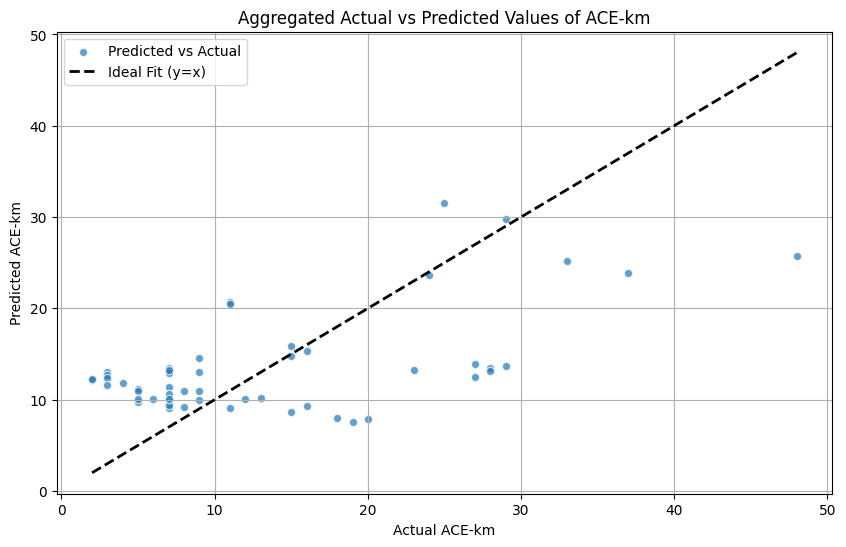


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 67.3014
R-squared: 0.3512


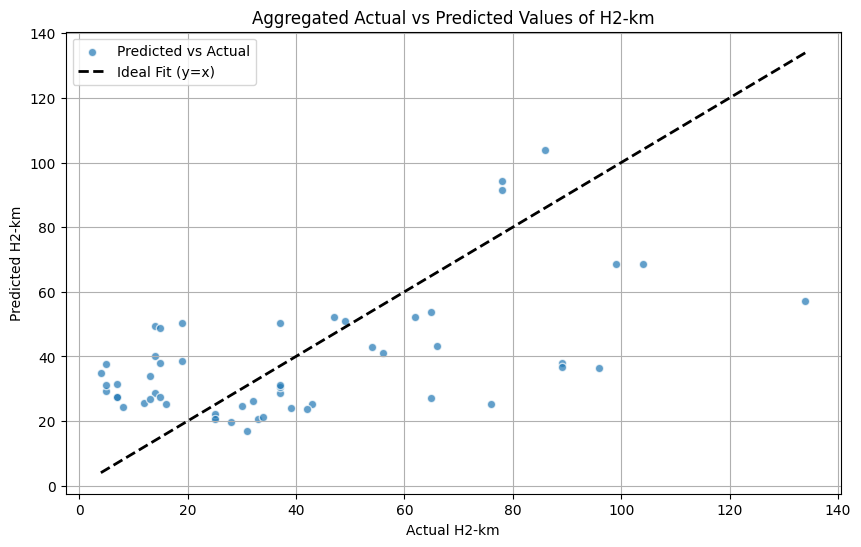


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 665.5525
R-squared: 0.3049


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler  # Use MinMaxScaler for normalization

# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data (adjust as necessary for your dataset)
# df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]
df_cleaned = df_use

# Identify digester columns
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

# Define groups for Leave-One-Group-Out cross-validation
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Remove only target columns from features
feature_columns = df_cleaned.columns.difference(target_columns)

# Identify non-target, non-digester columns for normalization
non_target_non_digester_columns = feature_columns.difference(digester_columns)

# Apply feature scaling (normalization) only to non-target, non-digester columns
scaler = MinMaxScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])

# Convert the data to float if necessary
df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Iterate over each target column
for target_column in target_columns:
    # Prepare features and target
    X = df_cleaned[feature_columns].values  # Features (includes digester columns)
    y = df_cleaned[target_column].values    # Target variable (not scaled)

    y_tests = []
    y_preds = []

    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split the data into training and testing sets based on digester groups
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Initialize the Linear Regression model
        lr_model = LinearRegression()

        # Train the Linear Regression model
        lr_model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = lr_model.predict(X_test)

        # Collect the test targets and predictions
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


### Tree-Based Models

In [ ]:
# For features with value equal to < 1, remove those features.

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Initialize a dictionary to store feature importances
feature_importances = {}

for target_column in target_columns:
    # Prepare features and target
    X = df_cleaned.drop(columns=target_columns)
    y = df_cleaned[target_column]
    
    # Train a Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    # Store feature importances
    importances = rf_model.feature_importances_
    feature_importances[target_column] = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Display the top 10 important features for each target
for target, importance in feature_importances.items():
    print(f"\nTop 10 important features for {target} based on Random Forest:")
    print(importance.head(1000))


### Recursive Feature Selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Initialize a dictionary to store selected features for each target
selected_features_rfe = {}

for target_column in target_columns:
    # Prepare features and target
    X = df_cleaned.drop(columns=target_columns)
    y = df_cleaned[target_column]
    
    # Initialize the Linear Regression model
    lr_model = LinearRegression()
    
    # Use RFE to select features
    rfe = RFE(estimator=lr_model, n_features_to_select=10)  # Adjust n_features_to_select as needed
    rfe.fit(X, y)
    
    # Store selected features
    selected_features_rfe[target_column] = X.columns[rfe.support_].tolist()

# Display selected features for each target variable
for target, features in selected_features_rfe.items():
    print(f"\nSelected features for {target} based on RFE:")
    print(features)


### Principal Component Analysis

In [19]:
from sklearn.decomposition import PCA

# Prepare features
X = df_cleaned.drop(columns=target_columns)

# Apply PCA and select the top components
pca = PCA(n_components=10)  # Adjust n_components as needed
X_pca = pca.fit_transform(X)

# Now use X_pca as the feature set for modeling



Selected features for ACE-km based on RFE:
['d__Bacteria;p__Patescibacteria;c__Gracilibacteria;o__Candidatus_Peregrinibacteria;f__Candidatus_Peregrinibacteria;g__Candidatus_Peregrinibacteria', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__uncultured', 'd__Bacteria;p__Bacteroidota;c__Chlorobia;o__Chlorobiales;f__Chlorobiaceae;g__Chlorobaculum', 'd__Bacteria;p__Planctomycetota;c__Phycisphaerae;o__DG-20;f__DG-20;g__DG-20', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Chitinibacteraceae;g__Formivibrio', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Intestinimonas', 'd__Bacteria;p__Actinobacteriota;c__WCHB1-81;o__WCHB1-81;f__WCHB1-81;g__WCHB1-81', 'd__Bacteria;p__Patescibacteria;c__Saccharimonadia;o__Saccharimonadales;f__LWQ8;g__LWQ8', 'd__Bacteria;p__Acidobacteriota;c__Holophagae;o__Holophagales;f__Holophagaceae;g__Holophaga', 'd__Bacteria;p__Verrucomicrobiota;c__Chlamydiae;o__Chlamydia

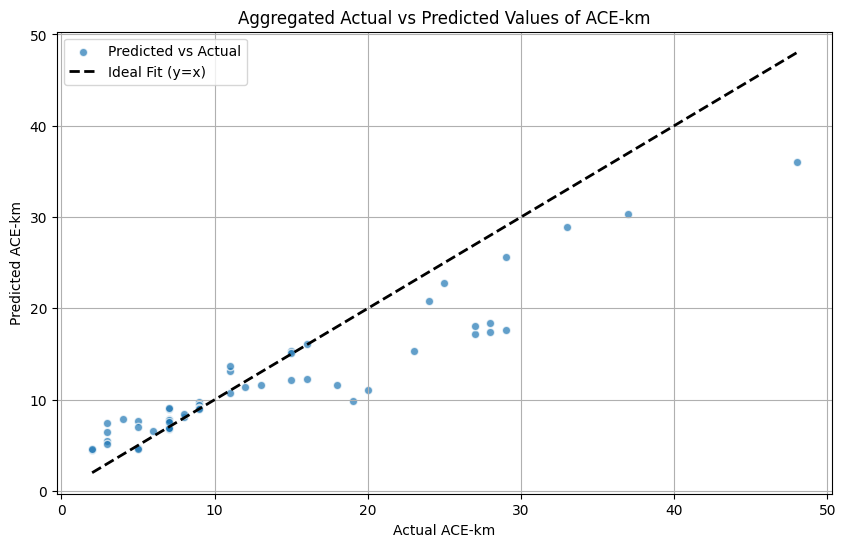


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 21.0393
R-squared: 0.7972


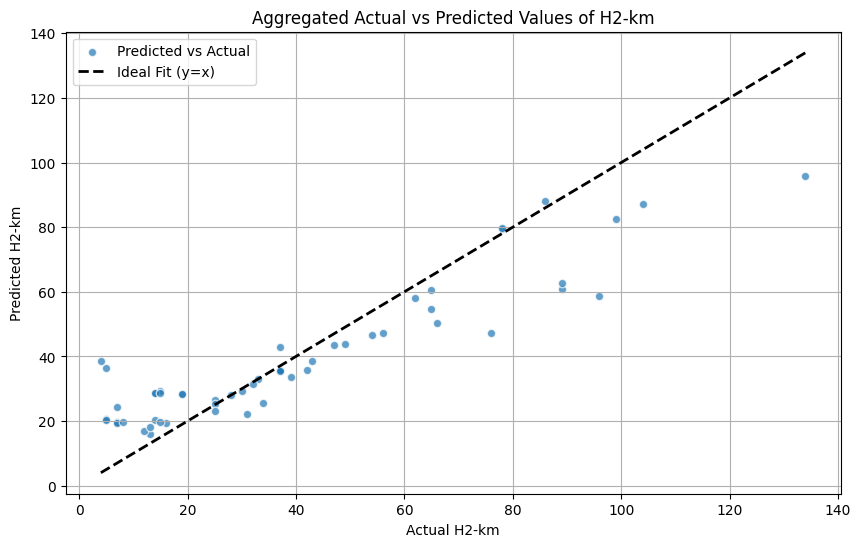


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 205.8963
R-squared: 0.7850


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data (adjust as necessary for your dataset)
df_cleaned = df_use

# Identify digester columns
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

# Define groups for Leave-One-Group-Out cross-validation
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Remove only target columns from features
feature_columns = df_cleaned.columns.difference(target_columns)

# Identify non-target, non-digester columns for normalization
non_target_non_digester_columns = feature_columns.difference(digester_columns)

# Apply feature scaling (normalization) only to non-target, non-digester columns
# scaler = MinMaxScaler()
# df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])

from sklearn.preprocessing import StandardScaler

# Apply standard scaling
scaler = StandardScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])


# Convert the data to float if necessary
df_cleaned = df_cleaned.astype(np.float32)

# Initialize a dictionary to store selected features for each target
selected_features_rfe = {}

# Perform Recursive Feature Elimination (RFE) to select features for each target
for target_column in target_columns:
    # Prepare features and target
    X = df_cleaned.drop(columns=target_columns)
    y = df_cleaned[target_column]
    
    # Initialize the Linear Regression model
    lr_model = LinearRegression()
    
    # Use RFE to select features
    rfe = RFE(estimator=lr_model, n_features_to_select=100)  # Adjust n_features_to_select as needed
    rfe.fit(X, y)
    
    # Store selected features
    selected_features_rfe[target_column] = X.columns[rfe.support_].tolist()

# Display selected features for each target variable
for target, features in selected_features_rfe.items():
    print(f"\nSelected features for {target} based on RFE:")
    print(features)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Iterate over each target column
for target_column in target_columns:
    # Use only the selected features for this target
    selected_features = selected_features_rfe.get(target_column, [])
    if not selected_features:
        print(f"No selected features found for target {target_column}. Skipping...")
        continue
    
    # Prepare features and target using the selected features and digester columns
    X = df_cleaned[selected_features + digester_columns].values  # Selected features + digester columns
    y = df_cleaned[target_column].values  # Target variable (not scaled)

    y_tests = []
    y_preds = []

    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split the data into training and testing sets based on digester groups
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Initialize the Linear Regression model
        lr_model = LinearRegression()

        # Train the Linear Regression model
        lr_model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = lr_model.predict(X_test)

        # Collect the test targets and predictions
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


### RFE applied to training data


Top 10 features for ACE-km based on RFE across folds:
d__Bacteria;p__Cloacimonadota;c__Cloacimonadia;o__Cloacimonadales;f__Cloacimonadaceae;g__LNR_A2-18: selected in 18 folds
d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Oligosphaerales;f__Oligosphaeraceae;g__Z20: selected in 18 folds
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;__: selected in 18 folds
d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__RBG-13-46-9;f__RBG-13-46-9;g__RBG-13-46-9: selected in 18 folds
d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae;g__DEV114: selected in 18 folds
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__M2PB4-65_termite_group;g__M2PB4-65_termite_group: selected in 18 folds
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Candidatus_Riegeria: selected in 18 folds
d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__GIF9;f__AB-539-J10;g__AB-539-J10: selected in 

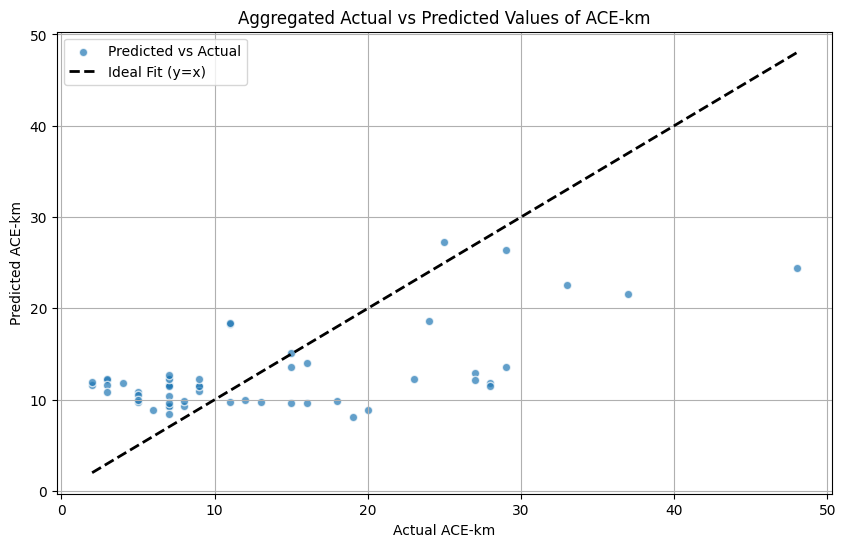


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 67.6774
R-squared: 0.3475

Top 10 features for H2-km based on RFE across folds:
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__Longilinea: selected in 18 folds
d__Bacteria;p__Verrucomicrobiota;c__Omnitrophia;o__Omnitrophales;f__Omnitrophales;g__Omnitrophales: selected in 18 folds
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__Leptolinea: selected in 18 folds
d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae;g__Desulfobulbus: selected in 18 folds
d__Bacteria;p__Spirochaetota;c__Leptospirae;o__Leptospirales;f__Leptospiraceae;g__RBG-16-49-21: selected in 18 folds
d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurovaceae;g__Sulfurovum: selected in 18 folds
d__Archaea;p__Euryarchaeota;c__Thermococci;o__Methanofastidiosales;f__Methanofastidiosales;g__Methanofastidiosales: selected in 18 f

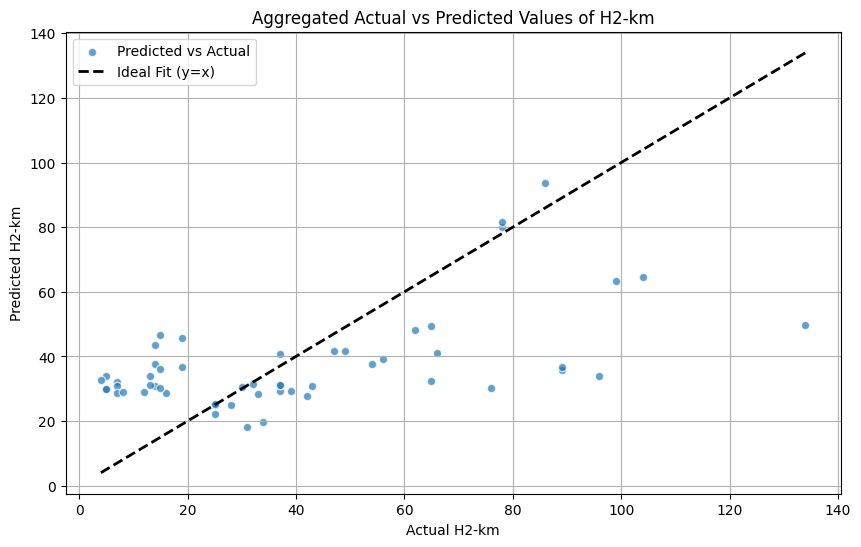


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 666.0145
R-squared: 0.3044


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from collections import Counter

# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data (adjust as necessary for your dataset)
df_cleaned = df_use

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Standardize only non-target, non-digester columns
non_target_non_digester_columns = df_cleaned.columns.difference(target_columns + digester_columns)
scaler = StandardScaler()
# scaler = MinMaxScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])

# Convert data to float if necessary
df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Iterate over each target column for model evaluation
for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns)
    y = df_cleaned[target_column]
    
    y_tests = []
    y_preds = []
    all_selected_features = []

    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the Linear Regression model and RFE
        lr_model = LinearRegression()
        rfe = RFE(estimator=lr_model, n_features_to_select=200)  # Select top 10 features
        
        # Fit RFE on the training data only
        rfe.fit(X_train, y_train)
        
        # Store selected features for this fold
        selected_features = X_train.columns[rfe.support_]
        all_selected_features.extend(selected_features)

        # Select features in both training and testing data
        X_train_rfe = X_train[selected_features]
        X_test_rfe = X_test[selected_features]

        # Train the Linear Regression model on the selected features
        lr_model.fit(X_train_rfe, y_train)

        # Predict on the test set
        y_pred = lr_model.predict(X_test_rfe)

        # Collect the test targets and predictions
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate and display top 10 features selected across all folds
    feature_counter = Counter(all_selected_features)
    top_features = feature_counter.most_common(10)
    print(f"\nTop 10 features for {target_column} based on RFE across folds:")
    for feature, count in top_features:
        print(f"{feature}: selected in {count} folds")

    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title(f'Aggregated Actual vs Predicted Values of {target_column}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")



Top 10 features for ACE-km based on RFE across folds:
d__Bacteria;p__Chloroflexi;c__Chloroflexia;o__Chloroflexales;f__Chloroflexaceae;g__FFCH7168: selected in 17 folds
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Magnetospiraceae;g__Magnetospiraceae: selected in 17 folds
Biomass_F: selected in 17 folds
d__Bacteria;p__Bacteroidota;c__Chlorobia;o__Chlorobiales;f__Chlorobiaceae;g__Chlorobaculum: selected in 16 folds
d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae;g__Desulfobulbus: selected in 16 folds
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__uncultured: selected in 16 folds
d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae;g__uncultured: selected in 16 folds
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__ADurb.Bin408;g__ADurb.Bin408: selected in 16 folds
d__Bacteria;p__Patescibacteria;c__Gracilibacteria;o__

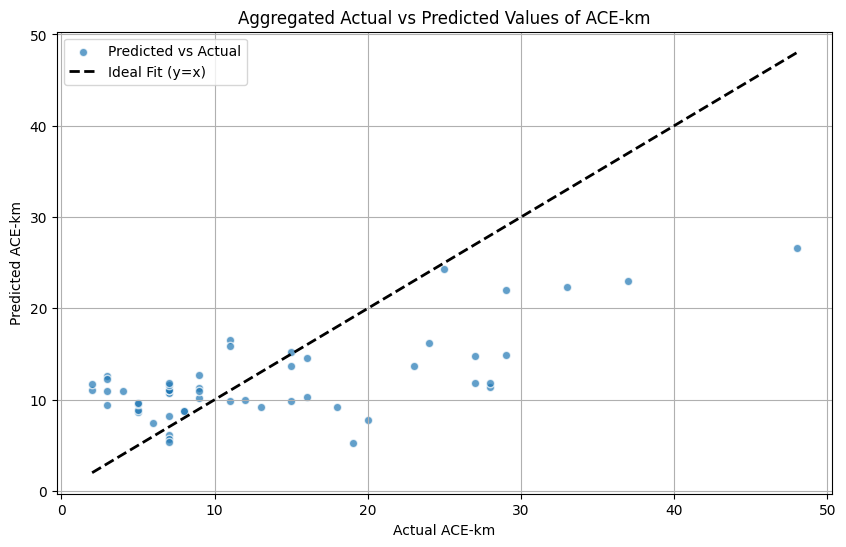


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 62.3715
R-squared: 0.3987


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data (adjust as necessary for your dataset)
df_cleaned = df_use

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Standardize only non-target, non-digester columns
non_target_non_digester_columns = df_cleaned.columns.difference(target_columns + digester_columns)
scaler = StandardScaler()
# scaler = MinMaxScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])

# Convert data to float if necessary
df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Iterate over each target column for model evaluation
for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns)
    y = df_cleaned[target_column]
    
    y_tests = []
    y_preds = []
    all_selected_features = []

    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the Linear Regression model and RFE
        lr_model = LinearRegression()
        rfe = RFE(estimator=lr_model, n_features_to_select=75)  # Select top 10 features
        
        # Fit RFE on the training data only
        rfe.fit(X_train, y_train)
        
        # Store selected features for this fold
        selected_features = X_train.columns[rfe.support_]
        all_selected_features.extend(selected_features)

        # Select features in both training and testing data
        X_train_rfe = X_train[selected_features]
        X_test_rfe = X_test[selected_features]

        # Train the Linear Regression model on the selected features
        lr_model.fit(X_train_rfe, y_train)

        # Predict on the test set
        y_pred = lr_model.predict(X_test_rfe)

        # Collect the test targets and predictions
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate and display top 10 features selected across all folds
    feature_counter = Counter(all_selected_features)
    top_features = feature_counter.most_common(10)
    print(f"\nTop 10 features for {target_column} based on RFE across folds:")
    for feature, count in top_features:
        print(f"{feature}: selected in {count} folds")

    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title(f'Aggregated Actual vs Predicted Values of {target_column}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


Top 10 features for H2-km based on RFE across folds:
d__Bacteria;p__Planctomycetota;c__Phycisphaerae;o__Phycisphaerales;f__AKAU3564_sediment_group;g__AKAU3564_sediment_group: selected in 18 folds
d__Bacteria;p__Desulfobacterota;c__Syntrophobacteria;o__Syntrophobacterales;f__Syntrophobacteraceae;g__Syntrophobacter: selected in 18 folds
d__Bacteria;p__Patescibacteria;c__Gracilibacteria;o__Candidatus_Peregrinibacteria;f__Candidatus_Peregrinibacteria;g__Candidatus_Peregrinibacteria: selected in 18 folds
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__Syntrophaceae;g__Syntrophus: selected in 18 folds
d__Bacteria;p__Firmicutes;c__D8A-2;o__D8A-2;f__D8A-2;g__D8A-2: selected in 18 folds
d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__FW22;f__FW22;g__FW22: selected in 18 folds
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__Longilinea: selected in 18 folds
d__Bacteria;p__Verrucomicrobiota;c__Omnitrophia;o__Omnitrophales;f__Omnitrophales;g__Om

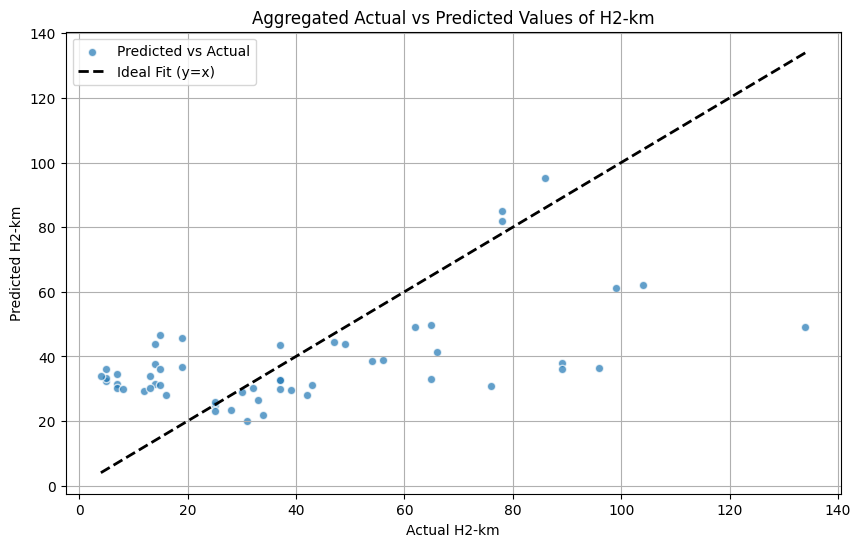


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 675.8911
R-squared: 0.2941


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from collections import Counter

# Target columns
target_columns = ['H2-km'] # ACE-km',

# Clean the data (adjust as necessary for your dataset)
df_cleaned = df_use

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Standardize only non-target, non-digester columns
non_target_non_digester_columns = df_cleaned.columns.difference(target_columns + digester_columns)
scaler = StandardScaler()
# scaler = MinMaxScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])

# Convert data to float if necessary
df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Iterate over each target column for model evaluation
for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns)
    y = df_cleaned[target_column]
    
    y_tests = []
    y_preds = []
    all_selected_features = []

    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the Linear Regression model and RFE
        lr_model = LinearRegression()
        rfe = RFE(estimator=lr_model, n_features_to_select=300)  # Select top 10 features
        
        # Fit RFE on the training data only
        rfe.fit(X_train, y_train)
        
        # Store selected features for this fold
        selected_features = X_train.columns[rfe.support_]
        all_selected_features.extend(selected_features)

        # Select features in both training and testing data
        X_train_rfe = X_train[selected_features]
        X_test_rfe = X_test[selected_features]

        # Train the Linear Regression model on the selected features
        lr_model.fit(X_train_rfe, y_train)

        # Predict on the test set
        y_pred = lr_model.predict(X_test_rfe)

        # Collect the test targets and predictions
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate and display top 10 features selected across all folds
    feature_counter = Counter(all_selected_features)
    top_features = feature_counter.most_common(10)
    print(f"\nTop 10 features for {target_column} based on RFE across folds:")
    for feature, count in top_features:
        print(f"{feature}: selected in {count} folds")

    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title(f'Aggregated Actual vs Predicted Values of {target_column}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")

### Processing separately


Top 10 features for ACE-km based on RFE across folds:
Biomass_F: selected in 18 folds
d__Bacteria;p__Bacteroidota;c__Chlorobia;o__Chlorobiales;f__Chlorobiaceae;g__Chlorobaculum: selected in 17 folds
d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallaceae: selected in 17 folds
d__Archaea;p__Micrarchaeota;c__Micrarchaeia;o__Micrarchaeales;f__Micrarchaeales;g__Micrarchaeales: selected in 17 folds
d__Archaea;p__Halobacterota;c__Methanosarcinia;o__Methanosarciniales;f__Methanosarcinaceae;g__Methanomethylovorans: selected in 17 folds
d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae;g__DEV114: selected in 17 folds
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__M2PB4-65_termite_group;g__M2PB4-65_termite_group: selected in 17 folds
d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae;g__Desulfobulbus: selected in 17 folds
d__Bacteria;p__Firmicutes;c__Bacill

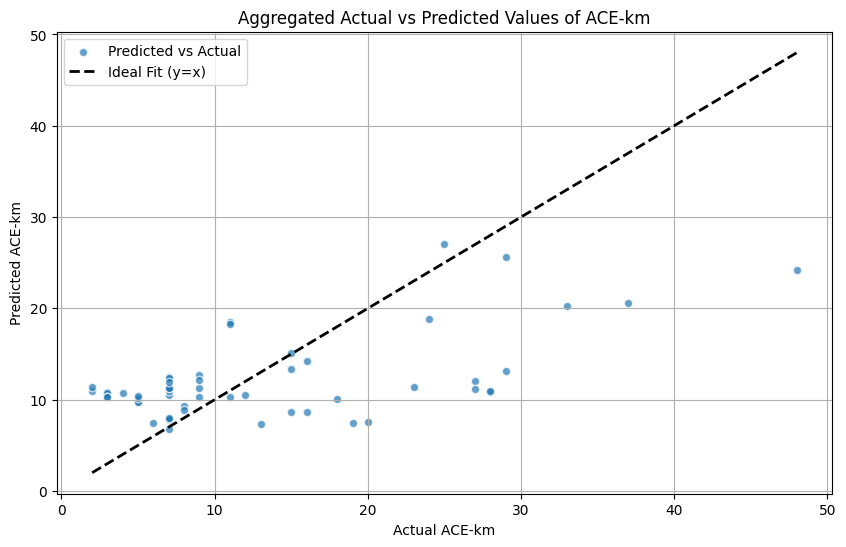


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 70.6378
R-squared: 0.3190

Top 10 features for H2-km based on RFE across folds:
d__Bacteria;p__Firmicutes;c__Bacilli;o__Acholeplasmatales;f__Acholeplasmataceae;__: selected in 18 folds
d__Bacteria;p__Verrucomicrobiota;c__Omnitrophia;o__Omnitrophales;f__Omnitrophales;g__Omnitrophales: selected in 17 folds
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;__: selected in 17 folds
d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae;g__Desulfobulbus: selected in 17 folds
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae;g__Lentimicrobiaceae: selected in 17 folds
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Anaerocella: selected in 17 folds
d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurovaceae;g__Sulfurovum: selected in 17 folds
d__Archaea;p__Altia

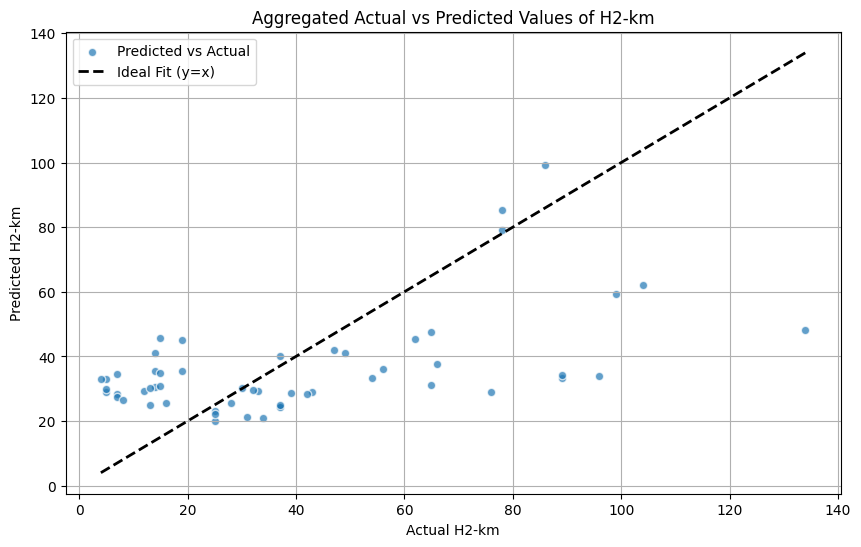


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 693.5443
R-squared: 0.2757


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from collections import Counter

# Clean the data (adjust as necessary for your dataset)
df_cleaned = df_use

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Standardize only non-target, non-digester columns
target_columns = ['H2-km'] # 'ACE-km',
non_target_non_digester_columns = df_cleaned.columns.difference(target_columns + digester_columns)
scaler = StandardScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])

# Convert data to float if necessary
df_cleaned = df_cleaned.astype(np.float32)

# Function to perform RFE and model evaluation for a given target column
def run_rfe_for_target(target_column):
    X = df_cleaned.drop(columns=target_columns)
    y = df_cleaned[target_column]
    
    y_tests = []
    y_preds = []
    all_selected_features = []

    # Initialize Leave-One-Group-Out cross-validator
    logo = LeaveOneGroupOut()

    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the Linear Regression model and RFE
        lr_model = LinearRegression()
        rfe = RFE(estimator=lr_model, n_features_to_select=100)  # Select top 100 features
        
        # Fit RFE on the training data only
        rfe.fit(X_train, y_train)
        
        # Store selected features for this fold
        selected_features = X_train.columns[rfe.support_]
        all_selected_features.extend(selected_features)

        # Select features in both training and testing data
        X_train_rfe = X_train[selected_features]
        X_test_rfe = X_test[selected_features]

        # Train the Linear Regression model on the selected features
        lr_model.fit(X_train_rfe, y_train)

        # Predict on the test set
        y_pred = lr_model.predict(X_test_rfe)

        # Collect the test targets and predictions
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate and display top 10 features selected across all folds
    feature_counter = Counter(all_selected_features)
    top_features = feature_counter.most_common(10)
    print(f"\nTop 10 features for {target_column} based on RFE across folds:")
    for feature, count in top_features:
        print(f"{feature}: selected in {count} folds")

    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title(f'Aggregated Actual vs Predicted Values of {target_column}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")

# Run the function for each target feature independently
for target in target_columns:
    run_rfe_for_target(target)


### MRMR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from mrmr import mrmr_regression  # Import MRMR for regression tasks

# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data (adjust as necessary for your dataset)
df_cleaned = df_use

# Identify digester columns
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

# Define groups for Leave-One-Group-Out cross-validation
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Remove only target columns from features
feature_columns = df_cleaned.columns.difference(target_columns)

# Identify non-target, non-digester columns for normalization
non_target_non_digester_columns = feature_columns.difference(digester_columns)

# Apply feature scaling (normalization) only to non-target, non-digester columns
scaler = MinMaxScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])

# Convert the data to float if necessary
df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Iterate over each target column
for target_column in target_columns:
    print(f"\nProcessing target variable: {target_column}")
    
    # Prepare the target variable
    y = df_cleaned[target_column].values  # Target variable (not scaled)

    # Lists to collect test results for evaluation
    y_tests = []
    y_preds = []

    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(df_cleaned, y, groups):
        # Split the data into training and testing sets based on digester groups
        X_train = df_cleaned.iloc[train_index].drop(columns=target_columns)
        y_train = df_cleaned.iloc[train_index][target_column]
        X_test = df_cleaned.iloc[test_index].drop(columns=target_columns)
        y_test = df_cleaned.iloc[test_index][target_column].values

        # Perform MRMR on the training data to select top features
        selected_features = mrmr_regression(X_train, y_train, K=500)  # Adjust 'K' as needed
        
        # Include digester columns in the selected features for this fold
        selected_features += digester_columns

        # Filter training and testing data to include only selected features
        X_train_selected = X_train[selected_features].values
        X_test_selected = X_test[selected_features].values

        # Initialize the Linear Regression model
        lr_model = LinearRegression()

        # Train the Linear Regression model
        lr_model.fit(X_train_selected, y_train)

        # Predict on the test set
        y_pred = lr_model.predict(X_test_selected)

        # Collect the test targets and predictions
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


## Feature Analysis

In [3]:
import statsmodels.api as sm
import pandas as pd

# Assuming df_cleaned is your DataFrame and target_columns contain the target variables.
target_columns = ['ACE-km', 'H2-km']

# df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Initialize a dictionary to store p-values for each target variable
significant_features = {}

for target in target_columns:
    # Separate the target variable
    y = df_use[target]
    # Select features (exclude target columns)
    X = df_use.drop(columns=target_columns)
    
    # Add a constant to the model for the intercept
    X = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Get p-values and filter significant features (e.g., p < 0.05)
    significant_features[target] = model.pvalues[model.pvalues < 0.05].index.tolist()

# Display the list of significant features for each target variable
print("Significant features based on p-values:")
for target, features in significant_features.items():
    print(f"{target}: {features}")


Significant features based on p-values:
ACE-km: []
H2-km: []


In [4]:
import statsmodels.api as sm
import pandas as pd

# Assuming df_use is your DataFrame with encoded features and target_columns contain the target variables.
target_columns = ['ACE-km', 'H2-km']

# Initialize a dictionary to store p-values for each target variable
p_values = {}

for target in target_columns:
    # Separate the target variable
    y = df_use[target]
    # Select features (exclude target columns)
    X = df_use.drop(columns=target_columns)
    
    # Add a constant to the model for the intercept
    X = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Store p-values for analysis
    p_values[target] = model.pvalues

# Display the p-values for each feature with respect to each target variable
for target, pvals in p_values.items():
    print(f"\nP-values for features in relation to target: {target}")
    print(pvals)

# Optionally, filter significant features based on a different threshold
# for example, using a higher threshold temporarily
significant_features = {target: pvals[pvals < 0.1].index.tolist() for target, pvals in p_values.items()}

print("\nPotentially significant features based on a higher p-value threshold (0.1):")
for target, features in significant_features.items():
    print(f"{target}: {features}")



P-values for features in relation to target: ACE-km
const                                                                                                                    NaN
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium                        NaN
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides                             NaN
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia                                NaN
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella   NaN
                                                                                                                          ..
Waste_PP                                                                                                                 NaN
Waste_PR                                                                

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = df_use.drop(columns=target_columns)
X = sm.add_constant(X)  # Add constant for VIF calculation if needed
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                                                feature  VIF
0                                                 const  0.0
1     d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...  inf
2     d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  inf
3     d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...  inf
4     d__Bacteria;p__Proteobacteria;c__Gammaproteoba...  inf
...                                                 ...  ...
1126                                           Waste_PP  inf
1127                                           Waste_PR  inf
1128                                          Waste_SDW  inf
1129                                          Biomass_F  inf
1130                                          Biomass_G  inf

[1131 rows x 2 columns]


In [10]:
df_use.head()

d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium  \
0                                                  0                                                   
1                                                  0                                                   
2                                                  0                                                   
3                                                  0                                                   
4                                                  0                                                   

   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides  \
0                                                  0                                              
1                                                  0                                              
2                                                  0                                              
3                                                  0                                              
4                                                  0                                              

   d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia  \
0                                                  0                                           
1                                                  0                                           
2                                           29557077                                           
3                                                  0                                           
4                                                  0                                           

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella  \
0                                                  0                                                                        
1                                                  0                                                                        
2                                                  0                                                                        
3                                                  0                                                                        
4                                                  0                                                                        

   d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Veillonella  \
0                                                  0                                                                
1                                                  0                                                                
2                                                  0                                                                
3                                                  0                                                                
4                                                  0                                                                

   d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium  \
0                                                  0                                                                 
1                                                  0                                                                 
2                                                  0                                                                 
3                                                  0                                                                 
4                                                  0                                                                 

   d__Bacteria;p__Bacteroidota;c__Bacteroid

In [7]:
vif_data

vif_data.to_csv('vif.csv', index=False)

In [3]:
print(df_use[['ACE-km', 'H2-km']].head())


  ACE-km H2-km
0    2.9   7.3
1    2.9   5.1
2    3.2   5.8
3   11.3  25.4
4    8.5  34.4


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

target_columns = ['ACE-km', 'H2-km']

df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

groups = df_cleaned[digester_columns].idxmax(axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cleaned[df_cleaned.columns] = scaler.fit_transform(df_cleaned)

df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    print(X.shape)
    
    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        model = build_model((X_train.shape[1], 1))

        model.fit(X_train, y_train, epochs=25, batch_size=16, verbose=0)

        y_pred = model.predict(X_test).flatten()

        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_76050/3433307842.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[df_cleaned.columns] = scaler.fit_transform(df_cleaned)


(54, 1132, 1)


1/1 [==============================] - 1s 538ms/step


1/1 [==============================] - 0s 494ms/step


1/1 [==============================] - 1s 509ms/step


1/1 [==============================] - 1s 697ms/step


KeyboardInterrupt: 

---------

## Absolute Abundance

## CNN

2024-11-10 15:17:15.357789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s

2024-11-10 15:17:22.724369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 253ms/step


2024-11-10 15:17:23.254200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 140ms/step


2024-11-10 15:17:29.290336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:17:29.684863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 111ms/step


2024-11-10 15:17:35.892852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:17:36.265833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 125ms/step


2024-11-10 15:17:42.864230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:17:43.287829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 182ms/step


2024-11-10 15:17:49.591743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:17:50.044598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 142ms/step


2024-11-10 15:17:56.630613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:17:57.093127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 131ms/step


2024-11-10 15:18:03.590855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:03.987308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 119ms/step


2024-11-10 15:18:10.891770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:11.338048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:18.305538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 241ms/step


2024-11-10 15:18:18.813240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 115ms/step


2024-11-10 15:18:25.174649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:25.556044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 199ms/step


2024-11-10 15:18:32.685024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:33.156864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 167ms/step


2024-11-10 15:18:39.841577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:40.292739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 193ms/step


2024-11-10 15:18:47.566097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:48.038379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 160ms/step


2024-11-10 15:18:54.632510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:18:55.040544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 165ms/step


2024-11-10 15:19:01.085960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:01.499803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-10 15:19:09.377259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:09.883484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 181ms/step


2024-11-10 15:19:14.610839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:15.085239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 165ms/step


2024-11-10 15:19:22.422683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


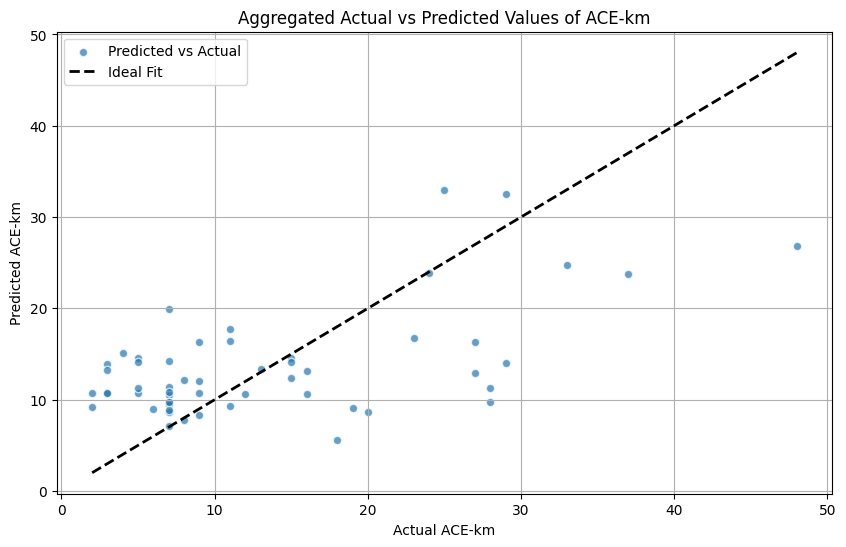


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 68.3436
R-squared: 0.3411


2024-11-10 15:19:23.075516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 144ms/step


2024-11-10 15:19:29.605098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:30.005716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 191ms/step


2024-11-10 15:19:36.519702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:36.958800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 227ms/step


2024-11-10 15:19:43.780653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:44.235827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 127ms/step


2024-11-10 15:19:50.487654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:50.858406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 199ms/step


2024-11-10 15:19:57.116694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:19:57.567079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 132ms/step


2024-11-10 15:20:03.626828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:04.013974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 178ms/step


2024-11-10 15:20:10.389448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:10.825628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 98ms/step


2024-11-10 15:20:17.069167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:17.410771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 172ms/step


2024-11-10 15:20:23.767713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:24.185605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 127ms/step


2024-11-10 15:20:30.364935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:30.740796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 122ms/step


2024-11-10 15:20:36.942476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:37.302041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 120ms/step


2024-11-10 15:20:39.488514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:39.848572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 129ms/step


2024-11-10 15:20:45.965628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:46.338084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 127ms/step


2024-11-10 15:20:52.472532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:52.842262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 169ms/step


2024-11-10 15:20:59.178333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:20:59.595394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 124ms/step


2024-11-10 15:21:05.712377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:21:06.061630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 158ms/step


2024-11-10 15:21:09.860404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 15:21:10.253386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 105ms/step


2024-11-10 15:21:16.402506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


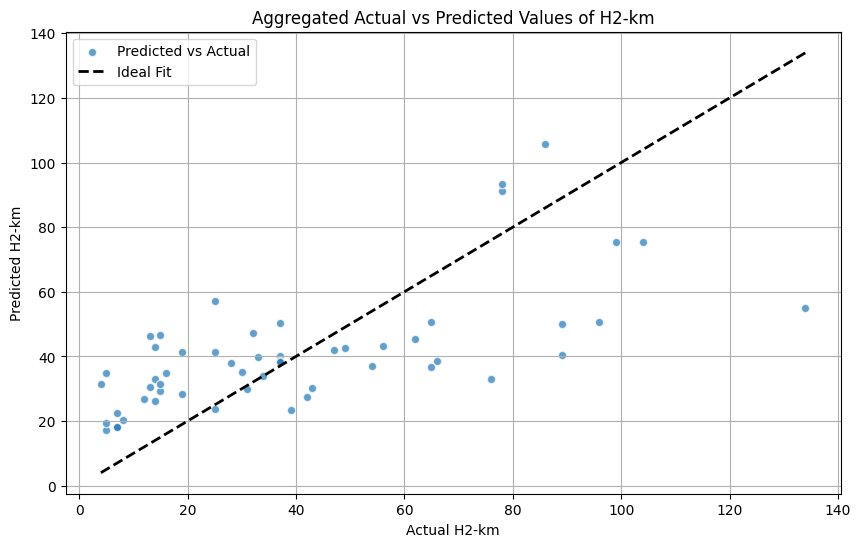


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 542.7433
R-squared: 0.4332


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model


# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data and remove rows with 'x'
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.select_dtypes(include=[np.number]).columns.difference(target_columns)
# scaler = MinMaxScaler()
# df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

from sklearn.preprocessing import StandardScaler

# Apply standard scaling
scaler = StandardScaler()
df_cleaned[non_target_non_digester_columns] = scaler.fit_transform(df_cleaned[non_target_non_digester_columns])


df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Perform cross-validation for each target
for target_column in target_columns:
    # Prepare data for the target variable
    X = df_cleaned.drop(columns=target_columns).values
    y = df_cleaned[target_column].values

    # Reshape X for Conv1D
    X = X.reshape(X.shape[0], X.shape[1], 1)

    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build and train the model
        model = build_model((X_train.shape[1], 1))
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, callbacks=[early_stopping])

        # Predict and store results
        y_pred = model.predict(X_test).flatten()
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Evaluate model performance
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


2024-11-12 16:32:40.455754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:32:49.350717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:32:52.976788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:33:03.803012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 871ms/step


2024-11-12 16:33:05.231402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:33:14.931567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:33:16.595870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:33:24.802285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 902ms/step


2024-11-12 16:33:26.242560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:33:35.166656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 875ms/step


2024-11-12 16:33:36.678873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:33:48.701614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:33:50.996874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:34:02.801528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:34:04.980425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:34:18.302778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:34:20.645613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:34:29.690599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:34:31.811664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:34:43.610997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:34:45.639399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:34:58.049872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:35:00.268931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:35:12.979754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:35:14.727574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:35:25.367690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:35:27.340252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:35:39.178698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:35:41.436960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:35:52.516375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:35:54.650742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:36:05.358560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:36:07.146332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:36:13.098695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:36:19.330293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:36:32.666764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


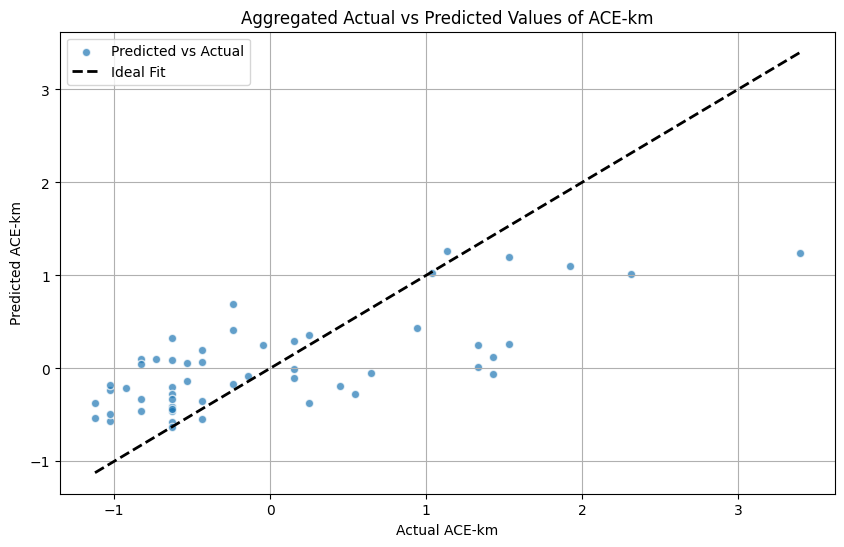


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 0.5266
R-squared: 0.4734


2024-11-12 16:36:34.979874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:36:47.913863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:36:49.951702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:36:59.836147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:37:01.938799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:37:17.065004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:37:19.034776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:37:37.551988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:37:39.427718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:37:55.389361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 620ms/step


2024-11-12 16:37:56.571550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:38:02.679992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:38:04.795585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:38:23.113484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:38:25.077896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:38:41.331453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:38:43.184785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:38:58.268616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:39:00.353417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:39:14.225448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:39:16.033928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:39:29.800178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:39:31.939178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:39:47.210162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 16:39:49.215086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:39:58.058774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:40:00.195948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:40:08.650273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 715ms/step


2024-11-12 16:40:09.908497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:40:26.327985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:40:28.453860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:40:42.250696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 708ms/step


2024-11-12 16:40:43.558788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:40:53.820945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 691ms/step


2024-11-12 16:40:55.127315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:41:07.755263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


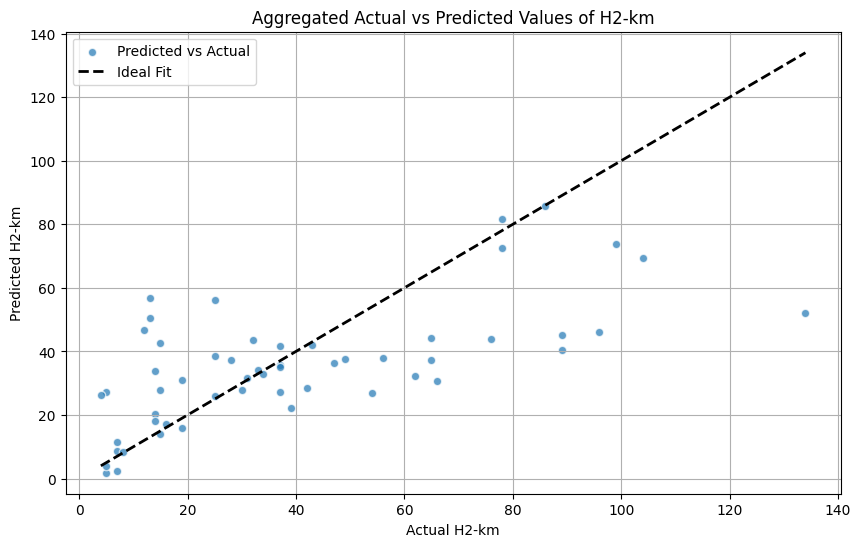


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 557.2056
R-squared: 0.4181


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.3),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model


# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data and remove rows with 'x'
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.select_dtypes(include=[np.number]).columns.difference(target_columns)
scaler = MinMaxScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

from sklearn.preprocessing import StandardScaler

# Apply standard scaling

df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Perform cross-validation for each target
for target_column in target_columns:
    # Prepare data for the target variable
    X = df_cleaned.drop(columns=target_columns).values
    y = df_cleaned[target_column].values

    # Reshape X for Conv1D
    X = X.reshape(X.shape[0], X.shape[1], 1)

    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build and train the model
        model = build_model((X_train.shape[1], 1))
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, callbacks=[early_stopping])

        # Predict and store results
        y_pred = model.predict(X_test).flatten()
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Evaluate model performance
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


2024-11-12 21:44:12.962966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:44:22.515448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 349ms/step


2024-11-12 21:44:23.382033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:44:35.491369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 321ms/step


2024-11-12 21:44:36.281738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:44:46.468099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 346ms/step


2024-11-12 21:44:47.291852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:44:58.377190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 299ms/step


2024-11-12 21:44:59.146997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:45:13.010802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 349ms/step


2024-11-12 21:45:13.833793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:45:26.045787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 384ms/step


2024-11-12 21:45:26.918757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:45:40.513301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 384ms/step


2024-11-12 21:45:41.396735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:45:51.325409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 358ms/step


2024-11-12 21:45:52.140533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:46:03.441395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 392ms/step


2024-11-12 21:46:06.169140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:46:10.006863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 367ms/step


2024-11-12 21:46:10.858455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:46:16.462422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 360ms/step


2024-11-12 21:46:17.293478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:46:21.116185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 394ms/step


2024-11-12 21:46:22.004164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:46:33.346456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 389ms/step


2024-11-12 21:46:34.217480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:46:44.165398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 401ms/step


2024-11-12 21:46:45.059311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:46:57.566878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 415ms/step


2024-11-12 21:46:58.452114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:47:10.139344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 395ms/step


2024-11-12 21:47:10.979162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:47:19.527995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 364ms/step


2024-11-12 21:47:20.335290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:47:24.125173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 364ms/step


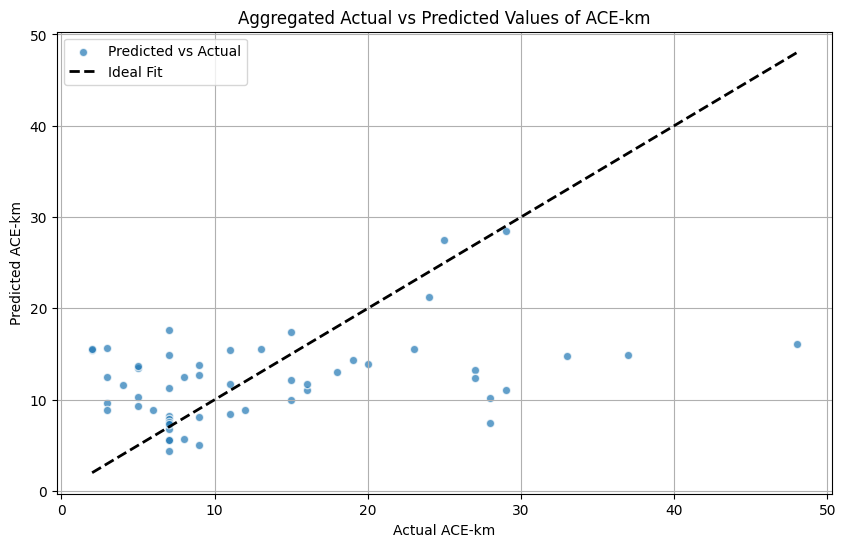


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 89.2962
R-squared: 0.1391


2024-11-12 21:47:26.991684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:47:36.700102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 379ms/step


2024-11-12 21:47:37.564753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:47:48.341270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 359ms/step


2024-11-12 21:47:49.145207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:48:00.381539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 382ms/step


2024-11-12 21:48:01.202704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:48:12.624977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 283ms/step


2024-11-12 21:48:13.350256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:48:24.007928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 442ms/step


2024-11-12 21:48:24.888822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:48:36.758541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 356ms/step


2024-11-12 21:48:37.609073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:48:49.313661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 366ms/step


2024-11-12 21:48:50.126062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:49:00.642652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 416ms/step


2024-11-12 21:49:04.187910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:49:16.047040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 460ms/step


2024-11-12 21:49:16.985402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:49:27.927917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 381ms/step


2024-11-12 21:49:28.785120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:49:41.875122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 457ms/step


2024-11-12 21:49:42.885587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:49:47.215820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 432ms/step


2024-11-12 21:49:48.131855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:50:01.029303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 396ms/step


2024-11-12 21:50:01.941357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:50:13.017227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 436ms/step


2024-11-12 21:50:13.911936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:50:18.034345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 360ms/step


2024-11-12 21:50:18.847359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:50:30.421217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 373ms/step


2024-11-12 21:50:31.233843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:50:37.652343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 418ms/step


2024-11-12 21:50:40.539183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 21:50:49.672836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 372ms/step


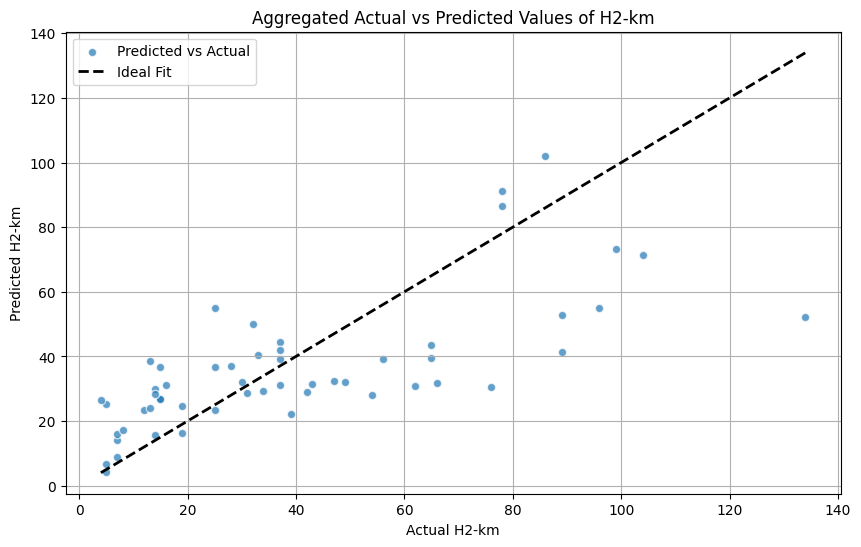


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 494.9078
R-squared: 0.4831


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.3),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model


# Target columns
target_columns = ['ACE-km', 'H2-km']

df_cleaned = df_use

# Clean the data and remove rows with 'x'
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.select_dtypes(include=[np.number]).columns.difference(target_columns)
scaler = MinMaxScaler()

df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

from sklearn.preprocessing import StandardScaler

# Apply standard scaling

df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Perform cross-validation for each target
for target_column in target_columns:
    # Prepare data for the target variable
    X = df_cleaned.drop(columns=target_columns).values
    y = df_cleaned[target_column].values

    # Reshape X for Conv1D
    X = X.reshape(X.shape[0], X.shape[1], 1)

    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build and train the model
        model = build_model((X_train.shape[1], 1))
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, callbacks=[early_stopping])

        # Predict and store results
        y_pred = model.predict(X_test).flatten()
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Evaluate model performance
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")

2024-11-12 16:57:36.691530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:57:55.972600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


2024-11-12 16:58:00.376281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:58:13.046883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:58:15.370146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:58:31.533924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:58:33.880156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:58:50.502889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:58:53.191952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:59:04.040106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 910ms/step


2024-11-12 16:59:05.675941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:59:27.349382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 16:59:30.242274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 16:59:50.700497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


2024-11-12 16:59:54.258110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:00:08.571524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 17:00:11.161757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:00:43.679167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


2024-11-12 17:00:48.520203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:01:03.073095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 17:01:05.519176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:01:23.103820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 17:01:25.309844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:01:40.513470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 17:01:42.523411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:01:52.844713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 17:01:54.766401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:02:14.835647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 17:02:17.171327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:02:25.744306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 17:02:27.952124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:02:44.677691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-11-12 17:02:47.106815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:02:59.626802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 17:03:01.775840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:03:13.185237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


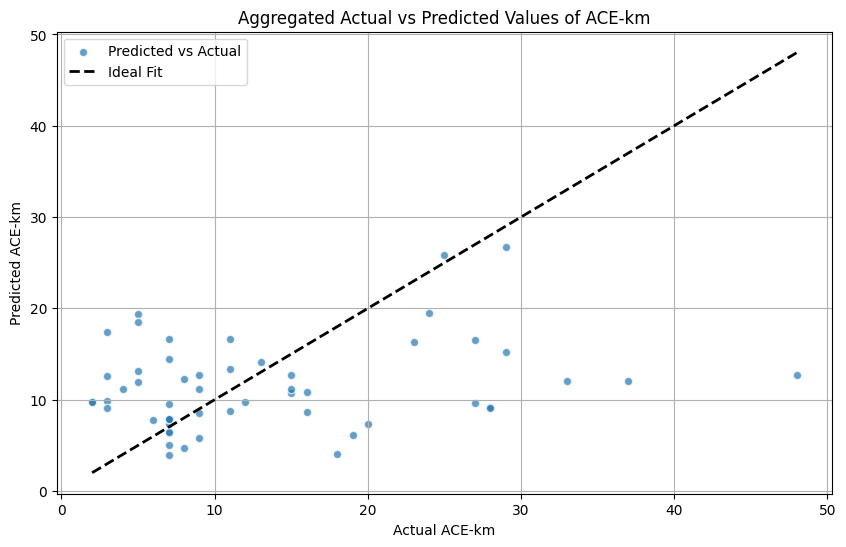


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 104.9749
R-squared: -0.0120


2024-11-12 17:03:15.535965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:03:27.233802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 17:03:29.071900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 17:03:45.820108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-11-12 17:03:47.733492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.3),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model


# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the data and remove rows with 'x'
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.select_dtypes(include=[np.number]).columns.difference(target_columns)
scaler = MinMaxScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

from sklearn.preprocessing import StandardScaler

# Apply standard scaling

df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Perform cross-validation for each target
for target_column in target_columns:
    # Prepare data for the target variable
    X = df_cleaned.drop(columns=target_columns).values
    y = df_cleaned[target_column].values

    # Reshape X for Conv1D
    X = X.reshape(X.shape[0], X.shape[1], 1)

    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build and train the model
        model = build_model((X_train.shape[1], 1))
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, callbacks=[early_stopping])

        # Predict and store results
        y_pred = model.predict(X_test).flatten()
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Evaluate model performance
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall results
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Function to build the neural network model
# def build_model(input_shape):
#     model = Sequential([
#         Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
#         Conv1D(filters=64, kernel_size=3, activation='relu'),
#         Dropout(0.3),
#         Conv1D(filters=32, kernel_size=3, activation='relu'),
#         Conv1D(filters=32, kernel_size=3, activation='relu'),
#         Dropout(0.3),
#         Flatten(),
#         Dense(32, activation='relu'),
#         Dense(1)
#     ])
#     model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
#     return model

def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

# Custom RFE-like feature selection function for neural network model
def custom_rfe_nn(df, target_column, n_features_to_select):
    non_target_columns = df.select_dtypes(include=[np.number]).columns.difference([target_column])
    selected_features = list(non_target_columns)  # Start with all features

    while len(selected_features) > n_features_to_select:
        feature_losses = {}
        
        # Evaluate the model performance by removing one feature at a time
        for feature in selected_features:
            current_features = [f for f in selected_features if f != feature]
            mse_loss = evaluate_nn_model(df[current_features], df[target_column], groups, target_column)
            feature_losses[feature] = mse_loss

        # Find the feature whose removal increases the loss the least
        least_important_feature = min(feature_losses, key=feature_losses.get)
        selected_features.remove(least_important_feature)
        print(f"Removed feature: {least_important_feature} (MSE: {feature_losses[least_important_feature]:.4f})")

    return selected_features

# Evaluate model function for given features (used within custom RFE)
def evaluate_nn_model(X, y, groups, target_column):
    # Reshape X for Conv1D
    X = X.values.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    y = y.values.astype(np.float32)

    # Initialize Leave-One-Group-Out cross-validator
    logo = LeaveOneGroupOut()
    y_tests, y_preds = [], []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build and train the model
        model = build_model((X_train.shape[1], 1))
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0, callbacks=[early_stopping])

        # Predict and store results
        y_pred = model.predict(X_test).flatten()
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate and return the MSE as the performance metric
    mse_loss = mean_squared_error(y_tests, y_preds)
    return mse_loss

# Main code for performing feature selection and evaluating the final model
target_columns = ['ACE-km', 'H2-km']
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Identify digester columns and define groups
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Normalize only the non-target columns
scaler = MinMaxScaler()
non_target_columns = df_cleaned.select_dtypes(include=[np.number]).columns.difference(target_columns)
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])
df_cleaned = df_cleaned.astype(np.float32)

# Perform feature selection for each target
for target_column in target_columns:
    selected_features = custom_rfe_nn(df_cleaned, target_column, n_features_to_select=10)
    print(f"\nSelected features for {target_column}: {selected_features}")

    # Final evaluation using selected features
    X_final = df_cleaned[selected_features]
    y_final = df_cleaned[target_column]
    mse_loss = evaluate_nn_model(X_final, y_final, groups, target_column)

    print(f"\nFinal Cross-Validation MSE for {target_column} with selected features: {mse_loss:.4f}")


2024-11-11 16:20:02.034952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:20:08.178926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 398ms/step


2024-11-11 16:20:09.132421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:20:14.809249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 336ms/step


2024-11-11 16:20:16.021778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:20:22.634926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 463ms/step


2024-11-11 16:20:23.676089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:20:32.064775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 433ms/step


2024-11-11 16:20:33.047690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:20:36.909117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 411ms/step


2024-11-11 16:20:37.864283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:20:45.111233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 446ms/step


2024-11-11 16:20:46.108989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:20:52.728115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 413ms/step


2024-11-11 16:20:53.693444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:01.049957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 356ms/step


2024-11-11 16:21:01.931890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:08.142884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 416ms/step


2024-11-11 16:21:10.831931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:19.400355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 461ms/step


2024-11-11 16:21:20.412147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:27.300232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 547ms/step


2024-11-11 16:21:28.443799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:32.796496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 476ms/step


2024-11-11 16:21:33.792656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:39.895067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 391ms/step


2024-11-11 16:21:40.976373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:50.577740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 465ms/step


2024-11-11 16:21:51.653282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:21:57.686213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 509ms/step


2024-11-11 16:21:58.793894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:22:07.592123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 368ms/step


2024-11-11 16:22:08.651041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:22:14.194128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 452ms/step


2024-11-11 16:22:18.252900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:22:25.449331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 516ms/step


2024-11-11 16:22:26.590264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:22:34.032607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 491ms/step


2024-11-11 16:22:35.067931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:22:40.891439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 451ms/step


2024-11-11 16:22:41.878881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:22:47.664215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 404ms/step


2024-11-11 16:22:48.647665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:22:55.785058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 472ms/step


2024-11-11 16:22:56.781575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:23:03.681429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 433ms/step


2024-11-11 16:23:04.632878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:23:13.266092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 419ms/step


2024-11-11 16:23:14.207946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:23:18.281647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 441ms/step


2024-11-11 16:23:21.020317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:23:27.232522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 467ms/step


2024-11-11 16:23:28.256040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:23:36.179435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 645ms/step


2024-11-11 16:23:37.412710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:23:46.375919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 594ms/step


2024-11-11 16:23:47.574103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:23:53.376079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 541ms/step


2024-11-11 16:23:54.526030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:24:01.555629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 464ms/step


2024-11-11 16:24:02.614630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:24:09.585114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 441ms/step


2024-11-11 16:24:10.595509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:24:17.609917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 495ms/step


2024-11-11 16:24:18.665347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:24:25.311930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 591ms/step


2024-11-11 16:24:28.512697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:24:38.387112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 624ms/step


2024-11-11 16:24:39.584979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:24:44.206600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 525ms/step


2024-11-11 16:24:45.278295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:24:51.680425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 494ms/step


2024-11-11 16:24:52.760342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:25:00.579983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 515ms/step


2024-11-11 16:25:01.627270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:25:10.192757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 470ms/step


2024-11-11 16:25:11.186454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:25:17.986470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 454ms/step


2024-11-11 16:25:18.977891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:25:27.177177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 655ms/step


2024-11-11 16:25:30.365236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:25:36.799229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 552ms/step


2024-11-11 16:25:37.953547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:25:46.551856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 707ms/step


2024-11-11 16:25:47.897378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:25:57.797015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 471ms/step


2024-11-11 16:25:58.796832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:26:06.120001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 455ms/step


2024-11-11 16:26:07.098581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:26:14.097752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 503ms/step


2024-11-11 16:26:15.122639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:26:22.588157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 832ms/step


2024-11-11 16:26:24.045356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:26:29.988461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 553ms/step


2024-11-11 16:26:31.075533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:26:38.306508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 511ms/step


2024-11-11 16:26:39.408510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:26:49.598452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 868ms/step


2024-11-11 16:26:53.628745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:02.057493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 844ms/step


2024-11-11 16:27:03.450814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:09.112800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 485ms/step


2024-11-11 16:27:10.140388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:18.634302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 517ms/step


2024-11-11 16:27:19.672627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:23.914494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 729ms/step


2024-11-11 16:27:25.209108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:32.028243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 561ms/step


2024-11-11 16:27:33.208486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:40.304039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 456ms/step


2024-11-11 16:27:41.322669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:49.302665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 543ms/step


2024-11-11 16:27:50.382919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 16:27:59.658961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


2024-11-11 16:28:01.061707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_19057/4042852546.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 689ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 693ms/step


1/1 [==============================] - 1s 663ms/step


1/1 [==============================] - 1s 667ms/step


1/1 [==============================] - 1s 702ms/step


1/1 [==============================] - 1s 710ms/step


1/1 [==============================] - 1s 693ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 1s 708ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 1s 687ms/step


1/1 [==============================] - 1s 716ms/step


1/1 [==============================] - 1s 718ms/step


1/1 [==============================] - 1s 882ms/step


1/1 [==============================] - 1s 707ms/step


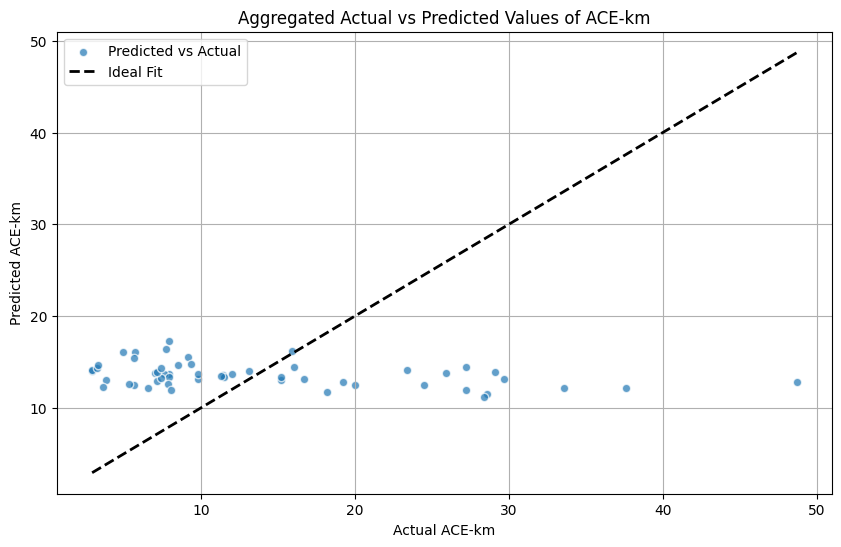


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 115.1482
R-squared: -0.1151


1/1 [==============================] - 1s 725ms/step


1/1 [==============================] - 1s 726ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 1s 724ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 721ms/step


1/1 [==============================] - 1s 737ms/step


1/1 [==============================] - 1s 882ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


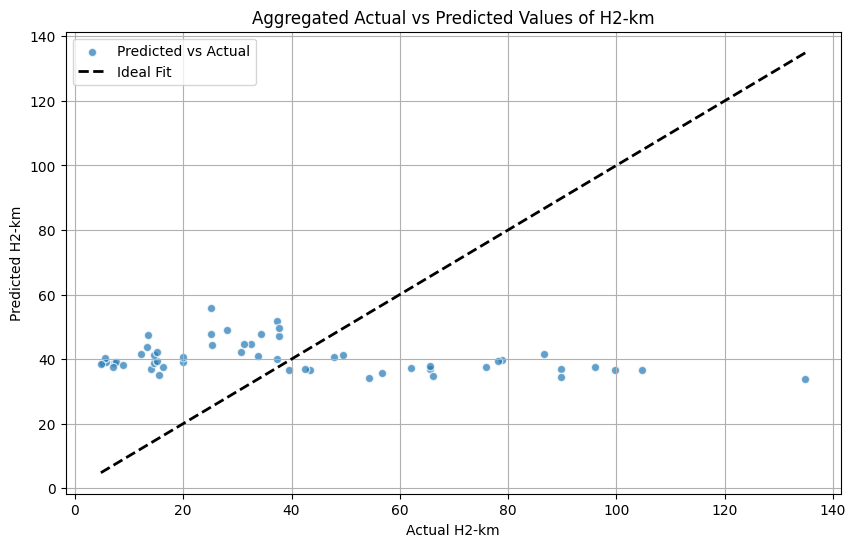


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 1081.8837
R-squared: -0.1256


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Function to build the ResNet model for 1D data with adjustable shortcut layers
def build_resnet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(inputs)
    
    # Residual Block 1
    x_shortcut = Conv1D(64, kernel_size=1, padding='same')(x)
    x = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(x)
    x = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(x)
    x = Add()([x, x_shortcut])  # Skip connection
    
    # Residual Block 2 with filter adjustment in shortcut path
    x_shortcut = Conv1D(128, kernel_size=1, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(x)
    x = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(x)
    x = Add()([x, x_shortcut])  # Skip connection
    
    # Residual Block 3 with filter adjustment in shortcut path
    x_shortcut = Conv1D(256, kernel_size=1, padding='same')(x)
    x = Conv1D(filters=256, kernel_size=1, activation='relu', padding='same')(x)
    x = Conv1D(filters=256, kernel_size=1, activation='relu', padding='same')(x)
    x = Add()([x, x_shortcut])  # Skip connection
    
    # Global Average Pooling and Dense Layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

target_columns = ['ACE-km', 'H2-km']

df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.columns.difference(target_columns)
scaler = MinMaxScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    
    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        model = build_resnet_model((X_train.shape[1], 1))

        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        y_pred = model.predict(X_test).flatten()

        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_19057/1231657014.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])


1/1 [==============================] - 1s 768ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 954ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 942ms/step


1/1 [==============================] - 1s 833ms/step


1/1 [==============================] - 1s 760ms/step


1/1 [==============================] - 1s 879ms/step


1/1 [==============================] - 1s 543ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 698ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 812ms/step


1/1 [==============================] - 1s 766ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 874ms/step


1/1 [==============================] - 1s 1s/step


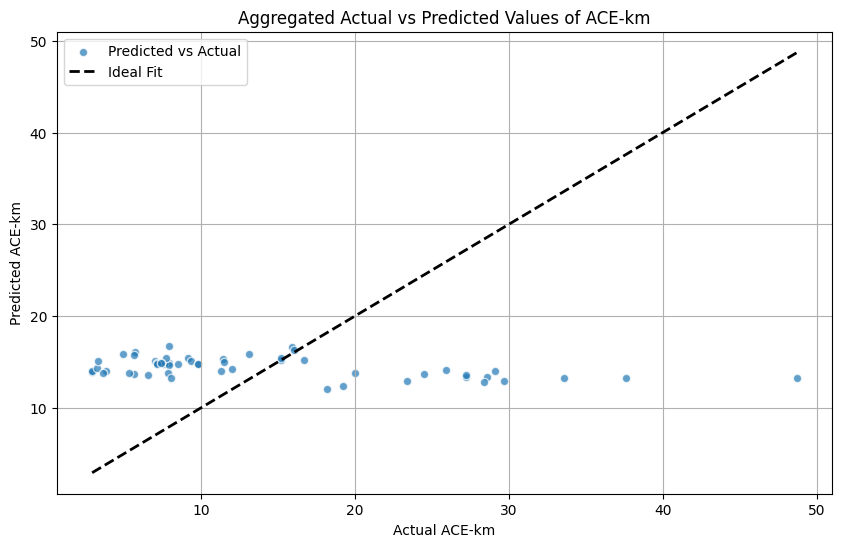


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 114.8914
R-squared: -0.1126


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 977ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 827ms/step


1/1 [==============================] - 1s 837ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 831ms/step


1/1 [==============================] - 1s 989ms/step


1/1 [==============================] - 1s 633ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 979ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 968ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


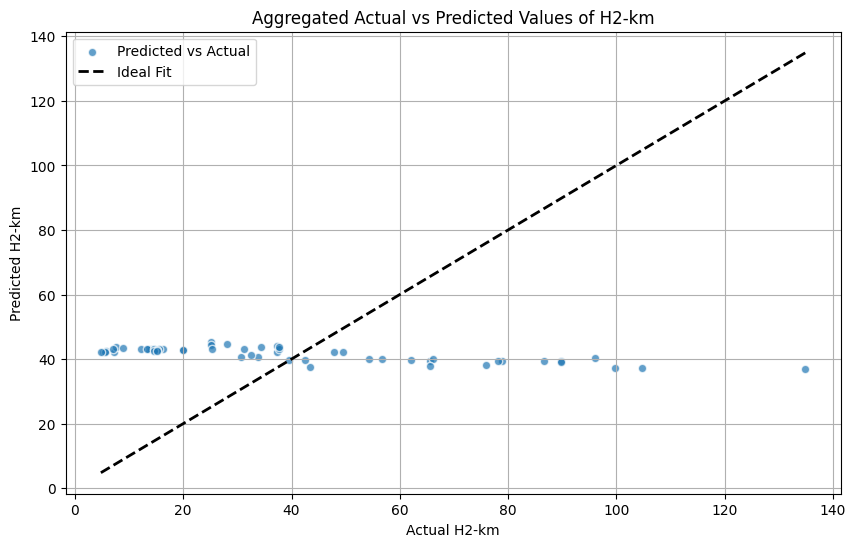


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 1072.8032
R-squared: -0.1162


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, GlobalAveragePooling1D, Add, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Function to build a Temporal Convolutional Network (TCN) model with matching shortcut layers
def build_tcn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First TCN Block with dilation rate = 1
    x = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=1)(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)
    
    # Second TCN Block with dilation rate = 2 and matching shortcut path
    x_shortcut = Conv1D(128, kernel_size=1, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu', dilation_rate=2)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)
    x = Add()([x, x_shortcut])  # Residual connection
    
    # Third TCN Block with dilation rate = 4 and matching shortcut path
    x_shortcut = Conv1D(256, kernel_size=1, padding='same')(x)
    x = Conv1D(filters=256, kernel_size=3, padding='causal', activation='relu', dilation_rate=4)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)
    x = Add()([x, x_shortcut])  # Residual connection

    # Global Pooling and Dense Layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

target_columns = ['ACE-km', 'H2-km']

df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.columns.difference(target_columns)
scaler = MinMaxScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    
    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        model = build_tcn_model((X_train.shape[1], 1))

        model.fit(X_train, y_train, epochs=25, batch_size=16, verbose=0)

        y_pred = model.predict(X_test).flatten()

        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_19057/2947105052.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])



Training and evaluating LSTM model...



1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


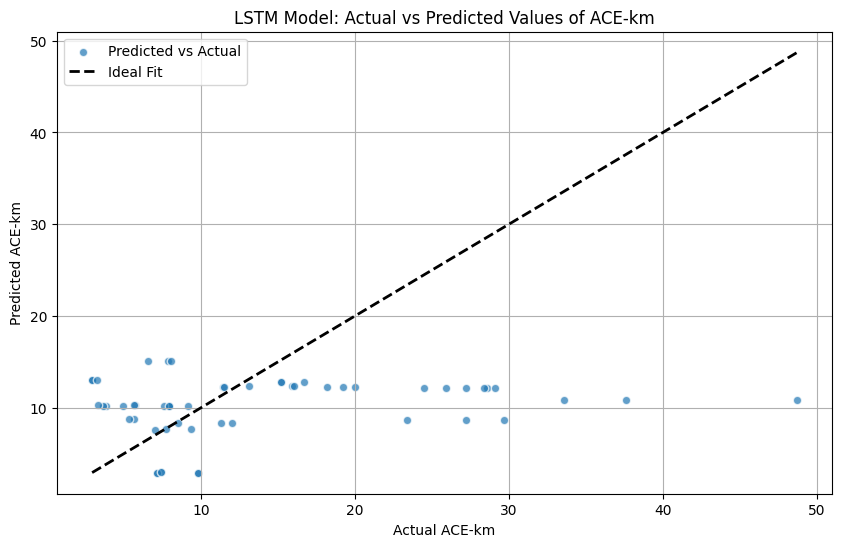

LSTM Model - ACE-km:
Mean Squared Error: 114.7896
R-squared: -0.1116



1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


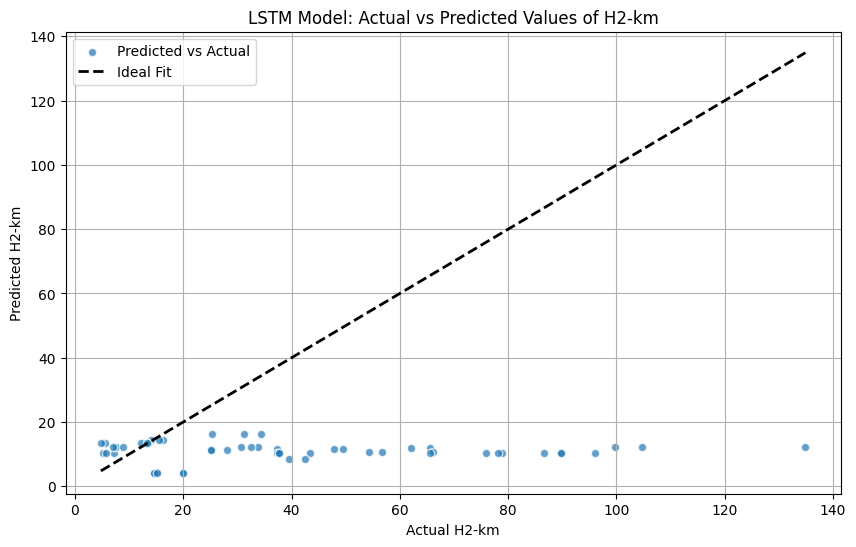

LSTM Model - H2-km:
Mean Squared Error: 1829.4620
R-squared: -0.9035


Training and evaluating CNN model...



1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 654ms/step


1/1 [==============================] - 1s 718ms/step


1/1 [==============================] - 1s 692ms/step


1/1 [==============================] - 1s 840ms/step


1/1 [==============================] - 1s 727ms/step


1/1 [==============================] - 1s 695ms/step


1/1 [==============================] - 1s 785ms/step


1/1 [==============================] - 1s 970ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 876ms/step


1/1 [==============================] - 1s 622ms/step


1/1 [==============================] - 1s 862ms/step


1/1 [==============================] - 1s 837ms/step


1/1 [==============================] - 1s 697ms/step


1/1 [==============================] - 1s 764ms/step


1/1 [==============================] - 1s 658ms/step


1/1 [==============================] - 1s 1s/step


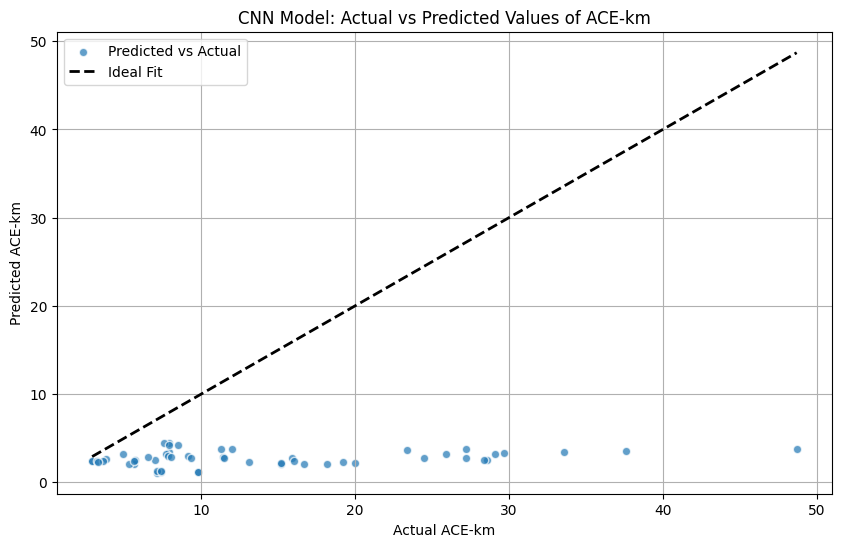

CNN Model - ACE-km:
Mean Squared Error: 224.2720
R-squared: -1.1719



1/1 [==============================] - 1s 765ms/step


1/1 [==============================] - 1s 819ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 1s 763ms/step


1/1 [==============================] - 1s 688ms/step


1/1 [==============================] - 1s 791ms/step


1/1 [==============================] - 1s 503ms/step


1/1 [==============================] - 1s 909ms/step


1/1 [==============================] - 1s 912ms/step


1/1 [==============================] - 1s 791ms/step


1/1 [==============================] - 1s 631ms/step


1/1 [==============================] - 1s 860ms/step


1/1 [==============================] - 1s 920ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 820ms/step


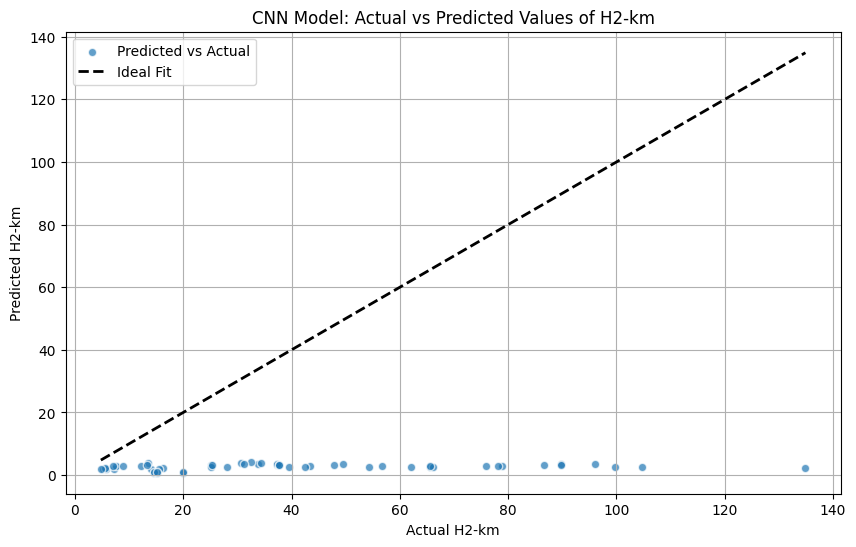

CNN Model - H2-km:
Mean Squared Error: 2368.0066
R-squared: -1.4638


Training and evaluating CNN-LSTM model...



1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


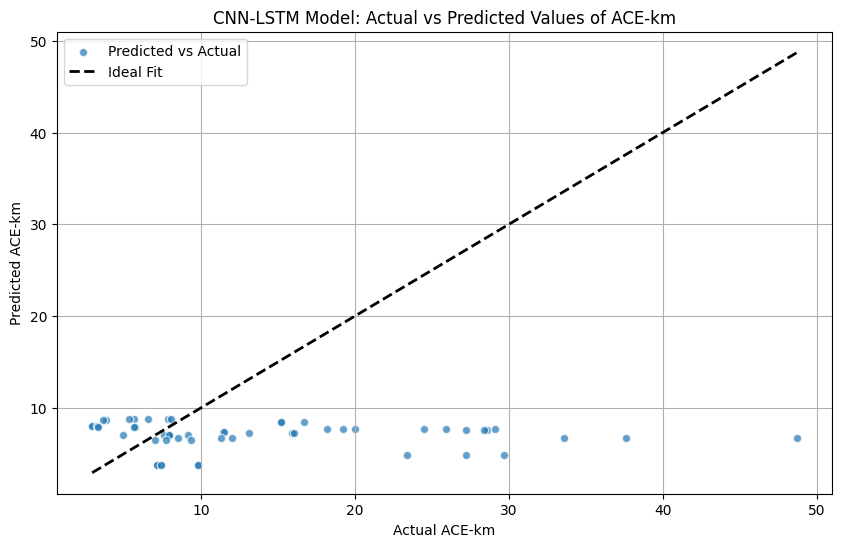

CNN-LSTM Model - ACE-km:
Mean Squared Error: 155.4971
R-squared: -0.5059



1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 965ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 3s 3s/step


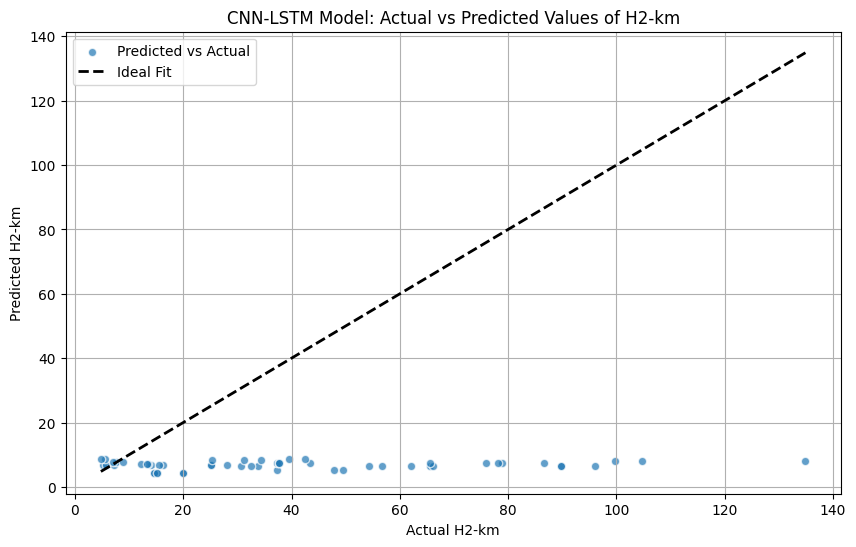

CNN-LSTM Model - H2-km:
Mean Squared Error: 2075.1174
R-squared: -1.1591



In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, GlobalAveragePooling1D, Add, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam

# Load and prepare data
target_columns = ['ACE-km', 'H2-km']
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# MinMax normalization for non-target columns
non_target_columns = df_cleaned.columns.difference(target_columns)
scaler = MinMaxScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])
df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

# Model Functions
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    attn_output = Add()([x, attn_output])
    attn_output = LayerNormalization()(attn_output)
    ffn_output = Dense(128, activation='relu')(attn_output)
    ffn_output = Dense(64, activation='relu')(ffn_output)
    ffn_output = Add()([attn_output, ffn_output])
    x = LayerNormalization()(ffn_output)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(64)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

def build_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

def build_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = LSTM(64)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

# Dictionary to store each model function
model_functions = {
    # "Transformer": build_transformer_model,
    "LSTM": build_lstm_model,
    "CNN": build_cnn_model,
    "CNN-LSTM": build_cnn_lstm_model
}

# Training and Evaluation Function
def train_and_evaluate_models():
    for model_name, model_func in model_functions.items():
        print(f"\nTraining and evaluating {model_name} model...\n")
        for target_column in target_columns:
            X = df_cleaned.drop(columns=target_columns).values  
            y = df_cleaned[target_column].values
            X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)

            y_tests, y_preds = [], []

            for train_index, test_index in logo.split(X, y, groups):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                y_train, y_test = y_train.astype(np.float32), y_test.astype(np.float32)
                
                model = model_func((X_train.shape[1], 1))
                model.fit(X_train, y_train, epochs=25, batch_size=16, verbose=0)
                
                y_pred = model.predict(X_test).flatten()
                y_tests.extend(y_test)
                y_preds.extend(y_pred)

            mse_overall = mean_squared_error(y_tests, y_preds)
            r2_overall = r2_score(y_tests, y_preds)

            # Scatter Plot
            plt.figure(figsize=(10, 6))
            plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
            plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
            plt.xlabel(f'Actual {target_column}')
            plt.ylabel(f'Predicted {target_column}')
            plt.title(f'{model_name} Model: Actual vs Predicted Values of {target_column}')
            plt.legend()
            plt.grid(True)
            plt.show()

            print(f"{model_name} Model - {target_column}:")
            print(f"Mean Squared Error: {mse_overall:.4f}")
            print(f"R-squared: {r2_overall:.4f}\n")

# Run the training and evaluation for all models
train_and_evaluate_models()


## VGG16

Epoch 1/50


2024-11-12 11:17:52.609257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 292.1356 - mae: 13.3529

2024-11-12 11:17:55.178362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 217.47633, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 292.1356 - mae: 13.3529 - val_loss: 217.4763 - val_mae: 14.6928 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 291.8118 - mae: 13.3522
Epoch 2: val_loss improved from 217.47633 to 217.33989, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 117ms/step - loss: 291.8118 - mae: 13.3522 - val_loss: 217.3399 - val_mae: 14.6882 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 291.4587 - mae: 13.3515
Epoch 3: val_loss improved from 217.33989 to 217.20219, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 216ms/step - loss: 291.4587 - mae: 13.3515 - val_loss: 217.2022 - val_mae: 14.6835 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 291.1082 

2024-11-12 11:18:01.997924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 439ms/step


Epoch 1/50


2024-11-12 11:18:02.844759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 273.7769 - mae: 12.6667

2024-11-12 11:18:04.792552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 700.91675, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 273.7769 - mae: 12.6667 - val_loss: 700.9167 - val_mae: 26.3566 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 273.2058 - mae: 12.6659
Epoch 2: val_loss improved from 700.91675 to 700.73553, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 115ms/step - loss: 273.2058 - mae: 12.6659 - val_loss: 700.7355 - val_mae: 26.3532 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 272.5800 - mae: 12.6652
Epoch 3: val_loss improved from 700.73553 to 700.55542, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 115ms/step - loss: 272.5800 - mae: 12.6652 - val_loss: 700.5554 - val_mae: 26.3497 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 271.9537 

2024-11-12 11:18:11.520717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 321ms/step


Epoch 1/50


2024-11-12 11:18:12.170457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 286.4108 - mae: 13.5192

2024-11-12 11:18:14.027219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 120.95296, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 286.4108 - mae: 13.5192 - val_loss: 120.9530 - val_mae: 10.9963 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 286.1602 - mae: 13.5185
Epoch 2: val_loss improved from 120.95296 to 120.93142, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 161ms/step - loss: 286.1602 - mae: 13.5185 - val_loss: 120.9314 - val_mae: 10.9953 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 285.9123 - mae: 13.5178
Epoch 3: val_loss improved from 120.93142 to 120.91018, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 114ms/step - loss: 285.9123 - mae: 13.5178 - val_loss: 120.9102 - val_mae: 10.9943 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 285.6721 

2024-11-12 11:18:21.097019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 344ms/step


Epoch 1/50


2024-11-12 11:18:25.939746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 290.9988 - mae: 13.8235

2024-11-12 11:18:29.233591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 48.57098, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 8s 8s/step - loss: 290.9988 - mae: 13.8235 - val_loss: 48.5710 - val_mae: 6.6568 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 290.8239 - mae: 13.8228
Epoch 2: val_loss improved from 48.57098 to 48.55543, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 136ms/step - loss: 290.8239 - mae: 13.8228 - val_loss: 48.5554 - val_mae: 6.6556 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 290.6437 - mae: 13.8220
Epoch 3: val_loss improved from 48.55543 to 48.54013, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 145ms/step - loss: 290.6437 - mae: 13.8220 - val_loss: 48.5401 - val_mae: 6.6545 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 290.4637 - mae: 13.8

2024-11-12 11:18:37.001585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 349ms/step


Epoch 1/50


2024-11-12 11:18:37.723506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 265.9405 - mae: 12.5882

2024-11-12 11:18:39.895556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 766.25464, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 265.9405 - mae: 12.5882 - val_loss: 766.2546 - val_mae: 27.6767 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 265.6450 - mae: 12.5874
Epoch 2: val_loss improved from 766.25464 to 766.07202, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 130ms/step - loss: 265.6450 - mae: 12.5874 - val_loss: 766.0720 - val_mae: 27.6734 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 265.3420 - mae: 12.5866
Epoch 3: val_loss improved from 766.07202 to 765.89087, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 111ms/step - loss: 265.3420 - mae: 12.5866 - val_loss: 765.8909 - val_mae: 27.6701 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 265.0484 

2024-11-12 11:18:46.941030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 382ms/step


Epoch 1/50


2024-11-12 11:18:47.669449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 292.1189 - mae: 13.8039

2024-11-12 11:18:49.654625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 48.89701, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 292.1189 - mae: 13.8039 - val_loss: 48.8970 - val_mae: 6.9901 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 292.0308 - mae: 13.8031
Epoch 2: val_loss did not improve from 48.89701
1/1 [==============================] - 0s 106ms/step - loss: 292.0308 - mae: 13.8031 - val_loss: 48.9196 - val_mae: 6.9917 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 291.9360 - mae: 13.8024
Epoch 3: val_loss did not improve from 48.89701
1/1 [==============================] - 0s 105ms/step - loss: 291.9360 - mae: 13.8024 - val_loss: 48.9436 - val_mae: 6.9934 - lr: 1.0000e-04


2024-11-12 11:18:50.436567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 332ms/step


Epoch 1/50


2024-11-12 11:18:51.100630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 258.9626 - mae: 12.6863

2024-11-12 11:18:53.102549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 680.19141, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 258.9626 - mae: 12.6863 - val_loss: 680.1914 - val_mae: 25.9903 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 258.8715 - mae: 12.6856
Epoch 2: val_loss improved from 680.19141 to 680.17126, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 128ms/step - loss: 258.8715 - mae: 12.6856 - val_loss: 680.1713 - val_mae: 25.9899 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 258.7643 - mae: 12.6848
Epoch 3: val_loss improved from 680.17126 to 680.15106, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 122ms/step - loss: 258.7643 - mae: 12.6848 - val_loss: 680.1511 - val_mae: 25.9895 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 258.6570 

2024-11-12 11:19:00.745702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 316ms/step


Epoch 1/50


2024-11-12 11:19:01.404642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 290.6283 - mae: 13.6078

2024-11-12 11:19:03.227017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 108.97176, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 290.6283 - mae: 13.6078 - val_loss: 108.9718 - val_mae: 10.2971 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 290.3983 - mae: 13.6069
Epoch 2: val_loss did not improve from 108.97176
1/1 [==============================] - 0s 113ms/step - loss: 290.3983 - mae: 13.6069 - val_loss: 109.0678 - val_mae: 10.3018 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 290.1306 - mae: 13.6060
Epoch 3: val_loss did not improve from 108.97176
1/1 [==============================] - 0s 144ms/step - loss: 290.1306 - mae: 13.6060 - val_loss: 109.1653 - val_mae: 10.3065 - lr: 1.0000e-04


2024-11-12 11:19:04.037248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 304ms/step


Epoch 1/50


2024-11-12 11:19:04.720882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 295.4486 - mae: 13.7500

2024-11-12 11:19:06.604285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 25.02962, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 295.4486 - mae: 13.7500 - val_loss: 25.0296 - val_mae: 4.9994 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 295.1039 - mae: 13.7492
Epoch 2: val_loss did not improve from 25.02962
1/1 [==============================] - 0s 103ms/step - loss: 295.1039 - mae: 13.7492 - val_loss: 25.0333 - val_mae: 4.9997 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 294.7304 - mae: 13.7485
Epoch 3: val_loss did not improve from 25.02962
1/1 [==============================] - 0s 105ms/step - loss: 294.7304 - mae: 13.7485 - val_loss: 25.0369 - val_mae: 5.0001 - lr: 1.0000e-04


2024-11-12 11:19:07.339555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 319ms/step


Epoch 1/50


2024-11-12 11:19:08.036618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 308.4703 - mae: 14.0784

2024-11-12 11:19:09.781667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 5.74342, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 308.4703 - mae: 14.0784 - val_loss: 5.7434 - val_mae: 2.3420 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 307.9875 - mae: 14.0776
Epoch 2: val_loss improved from 5.74342 to 5.72936, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 112ms/step - loss: 307.9875 - mae: 14.0776 - val_loss: 5.7294 - val_mae: 2.3390 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 307.5047 - mae: 14.0767
Epoch 3: val_loss improved from 5.72936 to 5.71509, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 113ms/step - loss: 307.5047 - mae: 14.0767 - val_loss: 5.7151 - val_mae: 2.3359 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 307.0306 - mae: 14.0758
Epoc

2024-11-12 11:19:16.523167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 315ms/step


Epoch 1/50


2024-11-12 11:19:17.189439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 288.5535 - mae: 13.8269

2024-11-12 11:19:18.971108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 8.90397, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 288.5535 - mae: 13.8269 - val_loss: 8.9040 - val_mae: 2.9780 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 288.4505 - mae: 13.8260
Epoch 2: val_loss did not improve from 8.90397
1/1 [==============================] - 0s 101ms/step - loss: 288.4505 - mae: 13.8260 - val_loss: 8.9216 - val_mae: 2.9809 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 288.3095 - mae: 13.8252
Epoch 3: val_loss did not improve from 8.90397
1/1 [==============================] - 0s 141ms/step - loss: 288.3095 - mae: 13.8252 - val_loss: 8.9394 - val_mae: 2.9839 - lr: 1.0000e-04


2024-11-12 11:19:19.737353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 317ms/step


Epoch 1/50


2024-11-12 11:19:20.382689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 301.2589 - mae: 13.0980

2024-11-12 11:19:22.191333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 362.04526, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 301.2589 - mae: 13.0980 - val_loss: 362.0453 - val_mae: 19.0089 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 300.8679 - mae: 13.0973
Epoch 2: val_loss improved from 362.04526 to 361.92929, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 120ms/step - loss: 300.8679 - mae: 13.0973 - val_loss: 361.9293 - val_mae: 19.0059 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 300.4626 - mae: 13.0965
Epoch 3: val_loss improved from 361.92929 to 361.81161, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 120ms/step - loss: 300.4626 - mae: 13.0965 - val_loss: 361.8116 - val_mae: 19.0028 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 300.0510 

2024-11-12 11:19:28.735789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2024-11-12 11:19:29.209901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 300.4324 - mae: 13.3137

2024-11-12 11:19:31.090916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 235.51587, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 300.4324 - mae: 13.3137 - val_loss: 235.5159 - val_mae: 15.3381 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 299.9267 - mae: 13.3129
Epoch 2: val_loss improved from 235.51587 to 235.49699, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 97ms/step - loss: 299.9267 - mae: 13.3129 - val_loss: 235.4970 - val_mae: 15.3375 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 299.3991 - mae: 13.3121
Epoch 3: val_loss improved from 235.49699 to 235.47685, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 92ms/step - loss: 299.3991 - mae: 13.3121 - val_loss: 235.4769 - val_mae: 15.3369 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 298.8621 - 

2024-11-12 11:19:37.414320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 316ms/step


Epoch 1/50


2024-11-12 11:19:38.055948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 303.2550 - mae: 13.7647

2024-11-12 11:19:39.926142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 59.89557, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 303.2550 - mae: 13.7647 - val_loss: 59.8956 - val_mae: 7.6793 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 302.6985 - mae: 13.7638
Epoch 2: val_loss improved from 59.89557 to 59.84877, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 124ms/step - loss: 302.6985 - mae: 13.7638 - val_loss: 59.8488 - val_mae: 7.6763 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 302.1241 - mae: 13.7630
Epoch 3: val_loss improved from 59.84877 to 59.80113, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 112ms/step - loss: 302.1241 - mae: 13.7630 - val_loss: 59.8011 - val_mae: 7.6732 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 301.5427 - mae: 13.7

2024-11-12 11:19:46.459000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 320ms/step


Epoch 1/50


2024-11-12 11:19:47.146307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 294.0924 - mae: 13.9608

2024-11-12 11:19:48.503153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 19.58072, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 294.0924 - mae: 13.9608 - val_loss: 19.5807 - val_mae: 4.3196 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 293.7415 - mae: 13.9600
Epoch 2: val_loss improved from 19.58072 to 19.56355, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 137ms/step - loss: 293.7415 - mae: 13.9600 - val_loss: 19.5636 - val_mae: 4.3176 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 293.3694 - mae: 13.9591
Epoch 3: val_loss improved from 19.56355 to 19.54627, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 117ms/step - loss: 293.3694 - mae: 13.9591 - val_loss: 19.5463 - val_mae: 4.3156 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 292.9912 - mae: 13.9

2024-11-12 11:19:55.236646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 340ms/step


Epoch 1/50


2024-11-12 11:19:55.938236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 314.5743 - mae: 13.8039
Epoch 1: val_loss improved from inf to 49.81184, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 1s 1s/step - loss: 314.5743 - mae: 13.8039 - val_loss: 49.8118 - val_mae: 7.0078 - lr: 1.0000e-04
Epoch 2/50


2024-11-12 11:19:56.809735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 314.2271 - mae: 13.8032
Epoch 2: val_loss did not improve from 49.81184
1/1 [==============================] - 0s 101ms/step - loss: 314.2271 - mae: 13.8032 - val_loss: 49.8578 - val_mae: 7.0111 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 313.8373 - mae: 13.8024
Epoch 3: val_loss did not improve from 49.81184
1/1 [==============================] - 0s 88ms/step - loss: 313.8373 - mae: 13.8024 - val_loss: 49.9047 - val_mae: 7.0144 - lr: 1.0000e-04


2024-11-12 11:19:57.247629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 360ms/step


Epoch 1/50


2024-11-12 11:19:57.943455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 310.5053 - mae: 14.1458

2024-11-12 11:19:59.868899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 59.49229, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 310.5053 - mae: 14.1458 - val_loss: 59.4923 - val_mae: 7.6527 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 310.2929 - mae: 14.1450
Epoch 2: val_loss did not improve from 59.49229
1/1 [==============================] - 0s 196ms/step - loss: 310.2929 - mae: 14.1450 - val_loss: 59.6015 - val_mae: 7.6599 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 310.0712 - mae: 14.1441
Epoch 3: val_loss did not improve from 59.49229
1/1 [==============================] - 0s 108ms/step - loss: 310.0712 - mae: 14.1441 - val_loss: 59.7117 - val_mae: 7.6670 - lr: 1.0000e-04


2024-11-12 11:20:00.633473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 394ms/step


Epoch 1/50


2024-11-12 11:20:01.584754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 206.3215 - mae: 11.9020

2024-11-12 11:20:04.068195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1588.28381, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 206.3215 - mae: 11.9020 - val_loss: 1588.2838 - val_mae: 39.3447 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 206.2117 - mae: 11.9011
Epoch 2: val_loss improved from 1588.28381 to 1588.08203, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 143ms/step - loss: 206.2117 - mae: 11.9011 - val_loss: 1588.0820 - val_mae: 39.3422 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 206.0940 - mae: 11.9002
Epoch 3: val_loss improved from 1588.08203 to 1587.88037, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 120ms/step - loss: 206.0940 - mae: 11.9002 - val_loss: 1587.8804 - val_mae: 39.3396 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2

2024-11-12 11:20:10.457804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 352ms/step


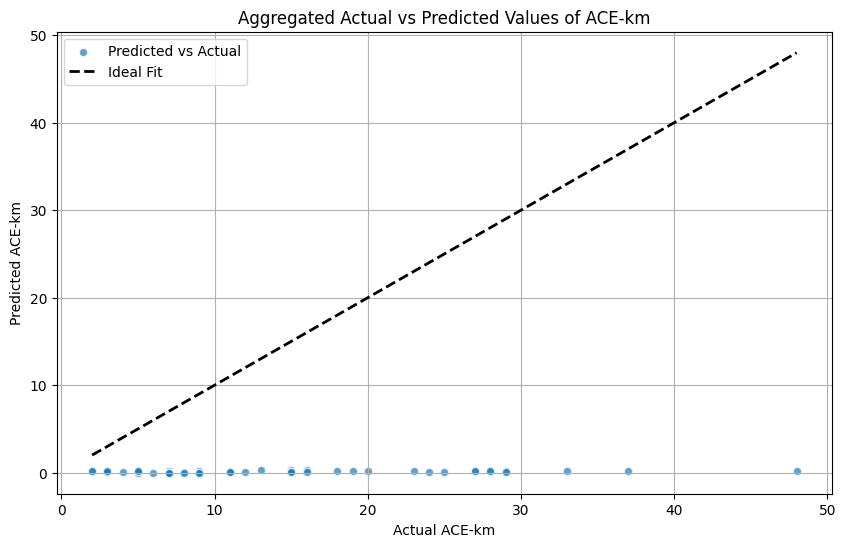


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 281.0532
R-squared: -1.7096
Epoch 1/50


2024-11-12 11:20:11.313077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2666.7063 - mae: 40.7255

2024-11-12 11:20:13.222807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 677.79675, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2666.7063 - mae: 40.7255 - val_loss: 677.7968 - val_mae: 25.9954 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2665.9150 - mae: 40.7247
Epoch 2: val_loss improved from 677.79675 to 677.71448, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 128ms/step - loss: 2665.9150 - mae: 40.7247 - val_loss: 677.7145 - val_mae: 25.9938 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2665.0400 - mae: 40.7240
Epoch 3: val_loss improved from 677.71448 to 677.63043, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 164ms/step - loss: 2665.0400 - mae: 40.7240 - val_loss: 677.6304 - val_mae: 25.9922 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2664

2024-11-12 11:20:19.505008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 354ms/step


Epoch 1/50


2024-11-12 11:20:20.187732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2211.0378 - mae: 36.8824

2024-11-12 11:20:26.390836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 8353.97266, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 8s 8s/step - loss: 2211.0378 - mae: 36.8824 - val_loss: 8353.9727 - val_mae: 91.3403 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2210.1851 - mae: 36.8816
Epoch 2: val_loss improved from 8353.97266 to 8353.83984, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 290ms/step - loss: 2210.1851 - mae: 36.8816 - val_loss: 8353.8398 - val_mae: 91.3395 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2209.3052 - mae: 36.8808
Epoch 3: val_loss improved from 8353.83984 to 8353.70312, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 242ms/step - loss: 2209.3052 - mae: 36.8808 - val_loss: 8353.7031 - val_mae: 91.3388 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

2024-11-12 11:20:34.101124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 610ms/step


Epoch 1/50


2024-11-12 11:20:35.192856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2457.7395 - mae: 39.0000

2024-11-12 11:20:37.649019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 4033.59741, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 2457.7395 - mae: 39.0000 - val_loss: 4033.5974 - val_mae: 63.4926 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2456.6406 - mae: 38.9993
Epoch 2: val_loss improved from 4033.59741 to 4033.35742, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 352ms/step - loss: 2456.6406 - mae: 38.9993 - val_loss: 4033.3574 - val_mae: 63.4907 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2455.5803 - mae: 38.9986
Epoch 3: val_loss improved from 4033.35742 to 4033.11230, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 275ms/step - loss: 2455.5803 - mae: 38.9986 - val_loss: 4033.1123 - val_mae: 63.4888 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

2024-11-12 11:20:44.452211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 333ms/step


Epoch 1/50


2024-11-12 11:20:45.136626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2663.3425 - mae: 40.3922

2024-11-12 11:20:46.977565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1004.76984, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2663.3425 - mae: 40.3922 - val_loss: 1004.7698 - val_mae: 31.6730 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2662.6296 - mae: 40.3914
Epoch 2: val_loss improved from 1004.76984 to 1004.72162, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 136ms/step - loss: 2662.6296 - mae: 40.3914 - val_loss: 1004.7216 - val_mae: 31.6722 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2661.8416 - mae: 40.3906
Epoch 3: val_loss improved from 1004.72162 to 1004.67523, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 111ms/step - loss: 2661.8416 - mae: 40.3906 - val_loss: 1004.6752 - val_mae: 31.6715 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

2024-11-12 11:20:52.798494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 301ms/step


Epoch 1/50


2024-11-12 11:20:53.460225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2517.1135 - mae: 38.8039

2024-11-12 11:20:55.327258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3469.23511, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2517.1135 - mae: 38.8039 - val_loss: 3469.2351 - val_mae: 58.6655 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2515.4663 - mae: 38.8031
Epoch 2: val_loss improved from 3469.23511 to 3469.02563, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 121ms/step - loss: 2515.4663 - mae: 38.8031 - val_loss: 3469.0256 - val_mae: 58.6637 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2513.6843 - mae: 38.8023
Epoch 3: val_loss improved from 3469.02563 to 3468.82642, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 112ms/step - loss: 2513.6843 - mae: 38.8023 - val_loss: 3468.8264 - val_mae: 58.6620 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

2024-11-12 11:21:01.500659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 308ms/step


Epoch 1/50


2024-11-12 11:21:02.199262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2446.0461 - mae: 38.6471

2024-11-12 11:21:04.495641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3947.40210, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2446.0461 - mae: 38.6471 - val_loss: 3947.4021 - val_mae: 61.3123 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2444.9141 - mae: 38.6463
Epoch 2: val_loss did not improve from 3947.40210
1/1 [==============================] - 0s 129ms/step - loss: 2444.9141 - mae: 38.6463 - val_loss: 3947.7883 - val_mae: 61.3155 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2443.7263 - mae: 38.6455
Epoch 3: val_loss did not improve from 3947.40210
1/1 [==============================] - 0s 123ms/step - loss: 2443.7263 - mae: 38.6455 - val_loss: 3948.1614 - val_mae: 61.3185 - lr: 1.0000e-04


2024-11-12 11:21:05.298045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 324ms/step


Epoch 1/50


2024-11-12 11:21:05.935351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 1939.3931 - mae: 35.6471

2024-11-12 11:21:07.830446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 12865.38770, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 1939.3931 - mae: 35.6471 - val_loss: 12865.3877 - val_mae: 112.3685 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1938.5251 - mae: 35.6462
Epoch 2: val_loss improved from 12865.38770 to 12864.40137, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 126ms/step - loss: 1938.5251 - mae: 35.6462 - val_loss: 12864.4014 - val_mae: 112.3641 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 1937.5425 - mae: 35.6454
Epoch 3: val_loss improved from 12864.40137 to 12863.39844, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 129ms/step - loss: 1937.5425 - mae: 35.6454 - val_loss: 12863.3984 - val_mae: 112.3596 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - E

2024-11-12 11:21:14.164029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 325ms/step


Epoch 1/50


2024-11-12 11:21:14.872223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2628.0442 - mae: 40.4902

2024-11-12 11:21:16.846134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 912.63727, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2628.0442 - mae: 40.4902 - val_loss: 912.6373 - val_mae: 29.9770 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2626.5784 - mae: 40.4894
Epoch 2: val_loss did not improve from 912.63727
1/1 [==============================] - 0s 107ms/step - loss: 2626.5784 - mae: 40.4894 - val_loss: 912.8729 - val_mae: 29.9810 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2624.8320 - mae: 40.4886
Epoch 3: val_loss did not improve from 912.63727
1/1 [==============================] - 0s 173ms/step - loss: 2624.8320 - mae: 40.4886 - val_loss: 913.1078 - val_mae: 29.9849 - lr: 1.0000e-04


2024-11-12 11:21:17.797164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 360ms/step


Epoch 1/50


2024-11-12 11:21:18.523648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2608.0896 - mae: 39.8846

2024-11-12 11:21:20.645852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1642.38428, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2608.0896 - mae: 39.8846 - val_loss: 1642.3843 - val_mae: 40.4981 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2607.0396 - mae: 39.8839
Epoch 2: val_loss improved from 1642.38428 to 1642.29028, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 151ms/step - loss: 2607.0396 - mae: 39.8839 - val_loss: 1642.2903 - val_mae: 40.4970 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2605.7622 - mae: 39.8832
Epoch 3: val_loss improved from 1642.29028 to 1642.19800, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 367ms/step - loss: 2605.7622 - mae: 39.8832 - val_loss: 1642.1980 - val_mae: 40.4958 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

2024-11-12 11:21:28.174103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2024-11-12 11:21:28.709008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2723.4373 - mae: 41.9216

2024-11-12 11:21:30.688936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 33.16795, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2723.4373 - mae: 41.9216 - val_loss: 33.1679 - val_mae: 5.6783 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2722.8679 - mae: 41.9207
Epoch 2: val_loss improved from 33.16795 to 33.14034, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 198ms/step - loss: 2722.8679 - mae: 41.9207 - val_loss: 33.1403 - val_mae: 5.6758 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2722.2715 - mae: 41.9198
Epoch 3: val_loss improved from 33.14034 to 33.11230, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 124ms/step - loss: 2722.2715 - mae: 41.9198 - val_loss: 33.1123 - val_mae: 5.6734 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2721.6738 - mae

2024-11-12 11:21:37.334305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 346ms/step


Epoch 1/50


2024-11-12 11:21:38.059842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2682.7405 - mae: 41.2692

2024-11-12 11:21:40.133904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 20.69026, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2682.7405 - mae: 41.2692 - val_loss: 20.6903 - val_mae: 4.5168 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2681.6948 - mae: 41.2685
Epoch 2: val_loss improved from 20.69026 to 20.64140, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 82ms/step - loss: 2681.6948 - mae: 41.2685 - val_loss: 20.6414 - val_mae: 4.5114 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2680.6628 - mae: 41.2677
Epoch 3: val_loss improved from 20.64140 to 20.59280, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 117ms/step - loss: 2680.6628 - mae: 41.2677 - val_loss: 20.5928 - val_mae: 4.5060 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2679.7263 - mae:

2024-11-12 11:21:47.878373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 380ms/step


Epoch 1/50


2024-11-12 11:21:48.657177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2710.4360 - mae: 41.3725

2024-11-12 11:21:50.592759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 225.76569, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2710.4360 - mae: 41.3725 - val_loss: 225.7657 - val_mae: 15.0021 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2709.3352 - mae: 41.3717
Epoch 2: val_loss improved from 225.76569 to 225.71324, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 84ms/step - loss: 2709.3352 - mae: 41.3717 - val_loss: 225.7132 - val_mae: 15.0003 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2708.0693 - mae: 41.3709
Epoch 3: val_loss improved from 225.71324 to 225.66005, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 99ms/step - loss: 2708.0693 - mae: 41.3709 - val_loss: 225.6600 - val_mae: 14.9985 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2706.8

2024-11-12 11:21:57.818816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2024-11-12 11:21:58.399467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2593.4800 - mae: 39.6471

2024-11-12 11:21:59.300697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1992.87939, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 2593.4800 - mae: 39.6471 - val_loss: 1992.8794 - val_mae: 44.3316 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2592.4072 - mae: 39.6463
Epoch 2: val_loss improved from 1992.87939 to 1992.66211, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 101ms/step - loss: 2592.4072 - mae: 39.6463 - val_loss: 1992.6621 - val_mae: 44.3291 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2591.0957 - mae: 39.6455
Epoch 3: val_loss improved from 1992.66211 to 1992.43555, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 108ms/step - loss: 2591.0957 - mae: 39.6455 - val_loss: 1992.4355 - val_mae: 44.3266 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

2024-11-12 11:22:05.458656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 364ms/step


Epoch 1/50


2024-11-12 11:22:06.191337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2689.4783 - mae: 41.5098

2024-11-12 11:22:08.090284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 160.54539, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2689.4783 - mae: 41.5098 - val_loss: 160.5454 - val_mae: 12.6605 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2688.2744 - mae: 41.5091
Epoch 2: val_loss improved from 160.54539 to 160.50383, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 139ms/step - loss: 2688.2744 - mae: 41.5091 - val_loss: 160.5038 - val_mae: 12.6588 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2687.0142 - mae: 41.5084
Epoch 3: val_loss improved from 160.50383 to 160.46060, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 122ms/step - loss: 2687.0142 - mae: 41.5084 - val_loss: 160.4606 - val_mae: 12.6571 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2685

2024-11-12 11:22:15.951311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2024-11-12 11:22:16.552351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2640.3289 - mae: 40.0784

2024-11-12 11:22:18.124286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1369.67834, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 2s 2s/step - loss: 2640.3289 - mae: 40.0784 - val_loss: 1369.6783 - val_mae: 37.0087 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2639.7139 - mae: 40.0777
Epoch 2: val_loss improved from 1369.67834 to 1369.56995, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 80ms/step - loss: 2639.7139 - mae: 40.0777 - val_loss: 1369.5699 - val_mae: 37.0072 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2638.9824 - mae: 40.0770
Epoch 3: val_loss improved from 1369.56995 to 1369.45935, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 122ms/step - loss: 2638.9824 - mae: 40.0770 - val_loss: 1369.4594 - val_mae: 37.0057 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - los

2024-11-12 11:22:24.982941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 345ms/step


Epoch 1/50


2024-11-12 11:22:25.714464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2710.4529 - mae: 41.8235

2024-11-12 11:22:27.656998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 54.04193, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2710.4529 - mae: 41.8235 - val_loss: 54.0419 - val_mae: 7.3338 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2709.7463 - mae: 41.8228
Epoch 2: val_loss did not improve from 54.04193
1/1 [==============================] - 0s 113ms/step - loss: 2709.7463 - mae: 41.8228 - val_loss: 54.0529 - val_mae: 7.3345 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2708.9663 - mae: 41.8220
Epoch 3: val_loss did not improve from 54.04193
1/1 [==============================] - 0s 117ms/step - loss: 2708.9663 - mae: 41.8220 - val_loss: 54.0648 - val_mae: 7.3353 - lr: 1.0000e-04


2024-11-12 11:22:28.479882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 420ms/step


Epoch 1/50


2024-11-12 11:22:29.256513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2839.1777 - mae: 42.8958
Epoch 1: val_loss improved from inf to 260.93674, saving model to ./VGG16_regression_task_weights.hdf5


2024-11-12 11:22:31.115481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 2839.1777 - mae: 42.8958 - val_loss: 260.9367 - val_mae: 16.0073 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2837.7122 - mae: 42.8949
Epoch 2: val_loss improved from 260.93674 to 260.89832, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 246ms/step - loss: 2837.7122 - mae: 42.8949 - val_loss: 260.8983 - val_mae: 16.0061 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2836.2937 - mae: 42.8941
Epoch 3: val_loss improved from 260.89832 to 260.85907, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 100ms/step - loss: 2836.2937 - mae: 42.8941 - val_loss: 260.8591 - val_mae: 16.0049 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2835.0193 - mae: 42.8932
Epoch 4: val_loss improved from 260.85907 to 260.81946, saving model to ./VGG16_reg

2024-11-12 11:22:37.361093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 384ms/step


Epoch 1/50


2024-11-12 11:22:38.121040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2343.4744 - mae: 37.5098

2024-11-12 11:22:40.163049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 6523.77100, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 2343.4744 - mae: 37.5098 - val_loss: 6523.7710 - val_mae: 80.6815 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2342.7949 - mae: 37.5090
Epoch 2: val_loss improved from 6523.77100 to 6523.23389, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 206ms/step - loss: 2342.7949 - mae: 37.5090 - val_loss: 6523.2339 - val_mae: 80.6781 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2341.9944 - mae: 37.5081
Epoch 3: val_loss improved from 6523.23389 to 6522.70703, saving model to ./VGG16_regression_task_weights.hdf5
1/1 [==============================] - 0s 118ms/step - loss: 2341.9944 - mae: 37.5081 - val_loss: 6522.7070 - val_mae: 80.6749 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

2024-11-12 11:22:46.892423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 390ms/step


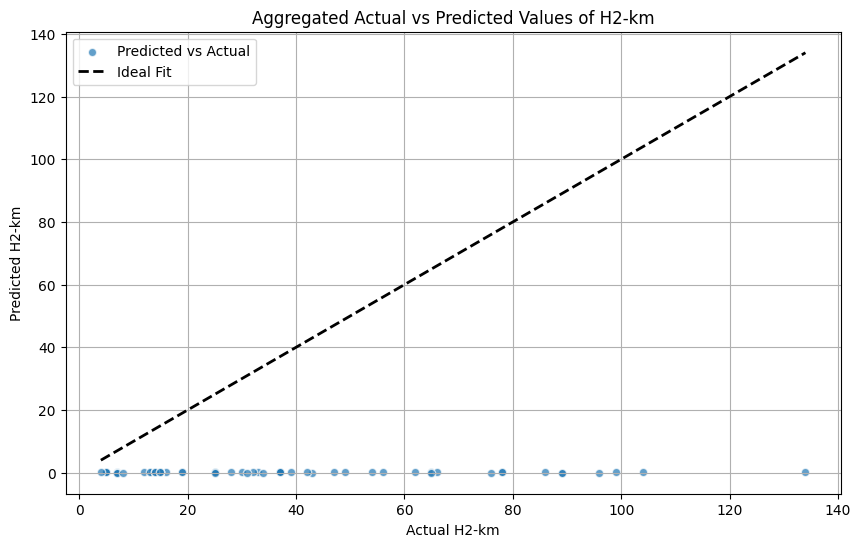


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 2540.7400
R-squared: -1.6534


In [24]:
import time
import sys
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, Callback
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, GlobalAveragePooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2  # Import L2 regularization
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Set constants
WIDTH = 224  # Initial assumption; will be dynamically adjusted based on data shape
BATCH_SIZE = 128
NB_EPOCH = 50
LEARNING_RATE = 1e-04
PATIENCE = 4
BN = True
LOW_DIM = 1  # For regression
PB_FLAG = 'regression_task'
ROOTPATH = './'  # Set your directory path for logs and weights

# Custom Callback to check for NaNs
class CheckNan(Callback):
    def on_batch_end(self, batch, logs={}):
        if math.isnan(logs.get('loss')):
            print("\nReached a NaN loss, terminating training.")
            sys.exit()

# Define the L2Model class for regression tasks
class L2Model:
    def __init__(self, input_shape):
        self.network = Sequential()
        
        # Initial Conv1D Layers with Batch Normalization and L2 regularization
        self.network.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
        self.network.add(BatchNormalization())
        self.network.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
        self.network.add(BatchNormalization())
        self.network.add(GlobalAveragePooling1D())
        
        if BN:
            self.network.add(BatchNormalization())
        self.network.add(Dense(LOW_DIM, activation='linear', kernel_regularizer=l2(0.001)))

        # Compile the model with a scheduler
        optimizer = Adam(learning_rate=LEARNING_RATE)
        self.network.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
    def fit(self, X_train, y_train, X_val, y_val):
        # Define callbacks
        csv_logger = CSVLogger(ROOTPATH + "VGG16_" + PB_FLAG + '_training.log')
        checkpointer = ModelCheckpoint(filepath=ROOTPATH + "VGG16_" + PB_FLAG + "_weights.hdf5", 
                                       monitor='val_loss', verbose=1, save_weights_only=True, 
                                       save_best_only=True, mode='min')
        early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # Reduced patience
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

        # Train the model
        self.network.fit(X_train, y_train, epochs=NB_EPOCH, batch_size=BATCH_SIZE, 
                         validation_data=(X_val, y_val), callbacks=[checkpointer, csv_logger, 
                                                                    early_stopping, lr_scheduler, CheckNan()])

    def predict(self, X_test):
        return self.network.predict(X_test).flatten()

# Main Setup for Loading Data and Running Cross-Validation
# Load and preprocess your data here
target_columns = ['ACE-km', 'H2-km']
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]  # Remove rows with 'x'
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.columns.difference(target_columns)
scaler = MinMaxScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

# Convert to float32 for compatibility
df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

# Run the model for each target column
for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    # Reshape X for compatibility with Conv1D
    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    
    # Set input shape dynamically
    input_shape = (X.shape[1], 1)
    
    y_tests = []
    y_preds = []

    # Leave-One-Group-Out Cross-Validation
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Initialize and train the model
        l2_model = L2Model(input_shape=input_shape)
        l2_model.fit(X_train, y_train, X_test, y_test)

        # Predict and store results
        y_pred = l2_model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate and display overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


## SVR

Fitting 18 folds for each of 18 candidates, totalling 324 fits


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_76050/4173586806.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])



Best parameters for ACE-km: {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}
Best CV Score (MSE): 67.3234


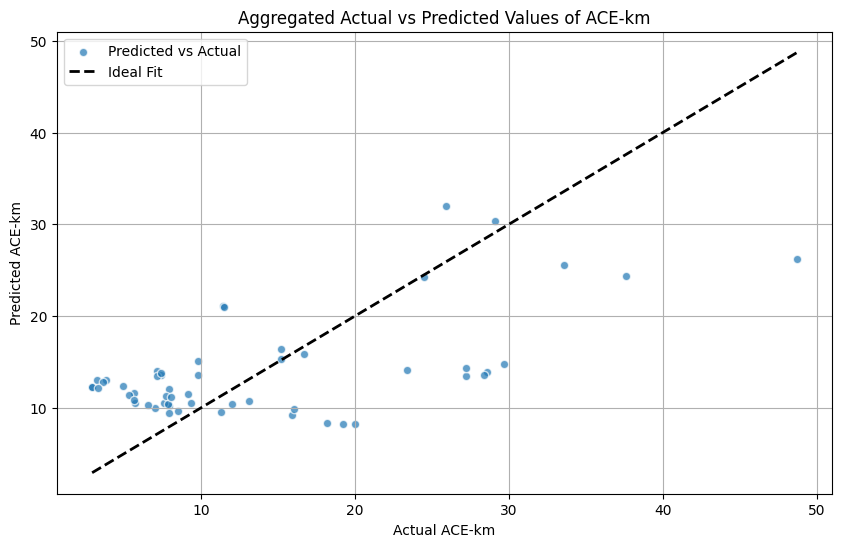


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 65.2898
R-squared: 0.3677
Fitting 18 folds for each of 18 candidates, totalling 324 fits

Best parameters for H2-km: {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
Best CV Score (MSE): 590.4131


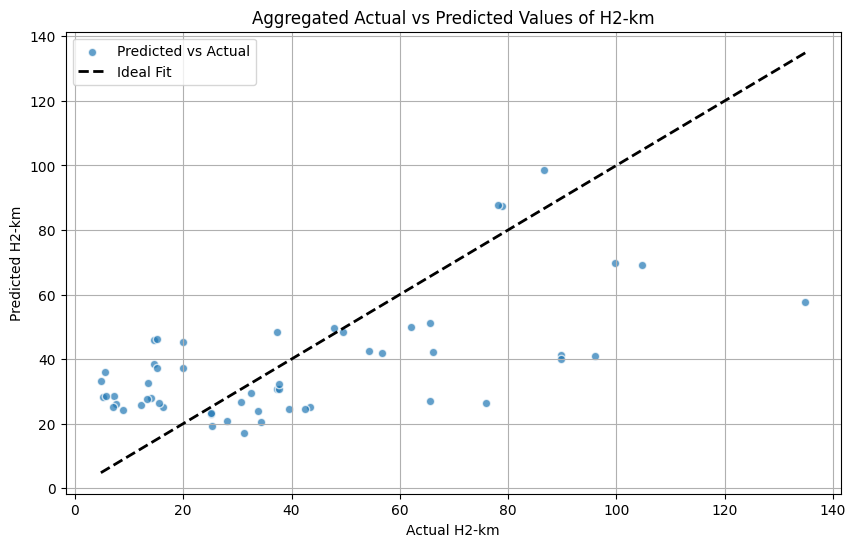


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 602.2282
R-squared: 0.3734


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

# List of target columns
target_columns = ['ACE-km', 'H2-km']

# Remove rows with 'x' values
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Ensure column names are strings
df_cleaned.columns = df_cleaned.columns.astype(str)

# Identify columns that start with 'Digester'
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

# Define groups based on the Digester columns
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Apply MinMax normalization only to non-target columns
non_target_columns = df_cleaned.columns.difference(target_columns)
scaler = MinMaxScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])

# Ensure the data type is float32
df_cleaned = df_cleaned.astype(np.float32)

# Define the parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf']
}

# Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Train and evaluate model for each target column
for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    X = X.astype(np.float32)
    
    y_tests = []
    y_preds = []

    # Initialize SVR model
    svr = SVR()

    # Set up GridSearchCV with LeaveOneGroupOut cross-validation
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=logo.split(X, y, groups),
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

    # Fit grid search
    grid_search.fit(X, y)

    # Best parameters and score
    print(f"\nBest parameters for {target_column}: {grid_search.best_params_}")
    print(f"Best CV Score (MSE): {abs(grid_search.best_score_):.4f}")

    # Get predictions with the best model
    best_model = grid_search.best_estimator_
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    # Calculate metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print overall cross-validation metrics
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")



=== Results for target: ACE-km ===

Training XGBoost...


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_76050/762266296.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])


Best parameters for XGBoost: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}

XGBoost - Mean Squared Error: 82.5051
XGBoost - R-squared: 0.2010


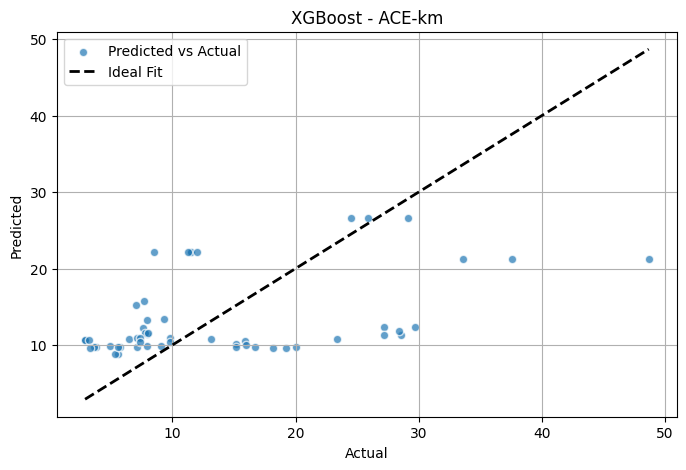


Training LightGBM...


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reaso

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 144
[LightGBM] [Info] Total Bins 1725
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1866
[LightGBM] [Info] Start training from score 11.351163[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 153

[LightGBM] [Info] Start training from score 15.741861
[LightGBM] [Info] Start trainin

  File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
  File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/subprocess.py", line 1847, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 188
[LightGBM] [Info] Start training from score 13.892593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

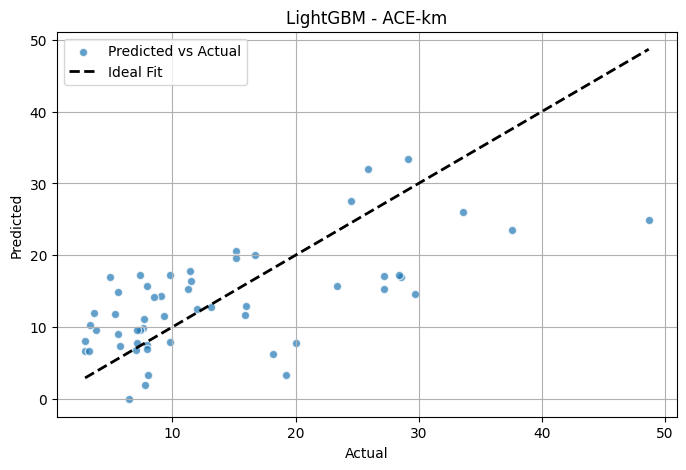


Training CatBoost...
Best parameters for CatBoost: {'learning_rate': 0.1, 'iterations': 100, 'depth': 5}

CatBoost - Mean Squared Error: 64.4589
CatBoost - R-squared: 0.3758


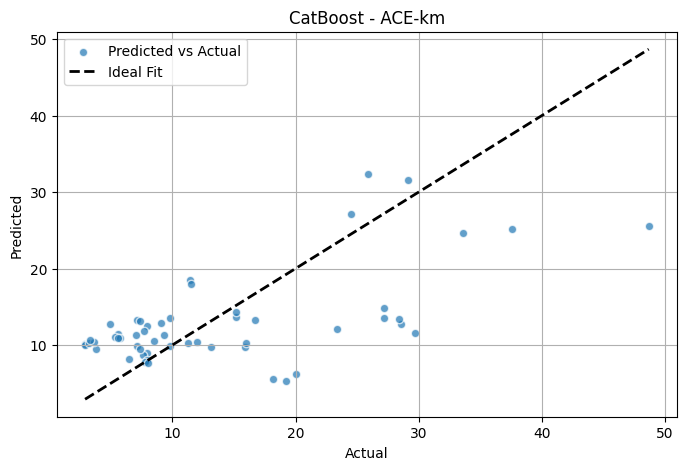


Training RandomForest...
Best parameters for RandomForest: {'n_estimators': 100, 'max_depth': None}

RandomForest - Mean Squared Error: 62.3594
RandomForest - R-squared: 0.3961


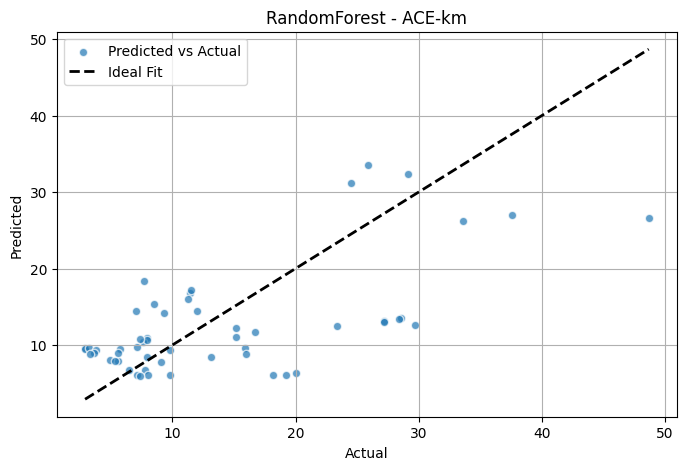


Training ElasticNet...


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.294e-01, tolerance: 4.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.242e-01, tolerance: 4.614e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Best parameters for ElasticNet: {'l1_ratio': 0.2, 'alpha': 1.0}

ElasticNet - Mean Squared Error: 76.2840
ElasticNet - R-squared: 0.2612


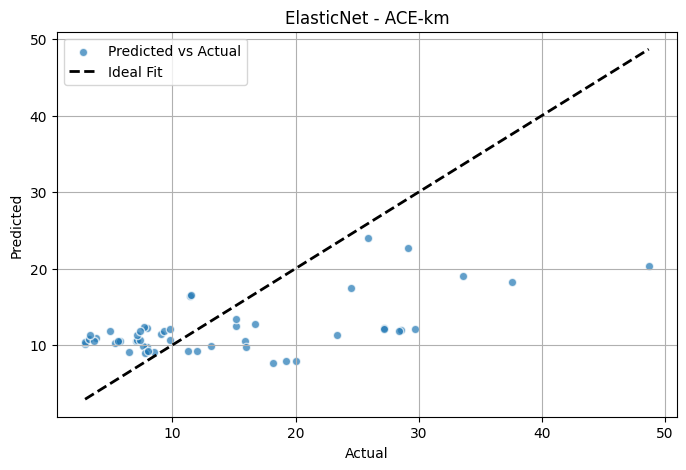


Training kNN...
Best parameters for kNN: {'n_neighbors': 5}

kNN - Mean Squared Error: 88.5501
kNN - R-squared: 0.1425


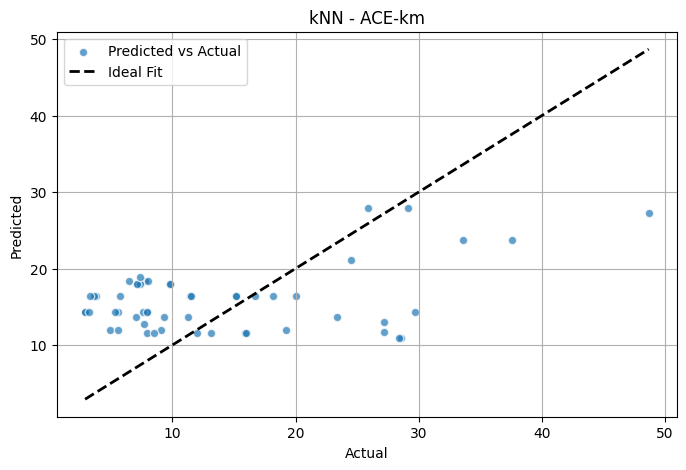


Training Neural Network for ACE-km...
1/1 [==============================] - 0s 39ms/step

Neural Network - Mean Squared Error: 24701.5723
Neural Network - R-squared: -238.2156


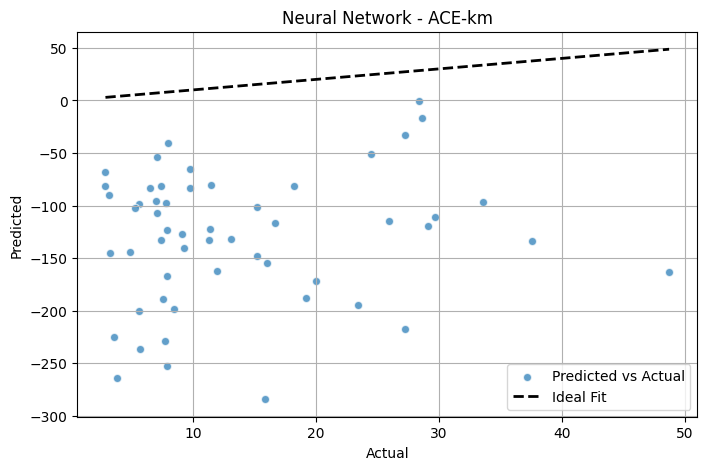


=== Results for target: H2-km ===

Training XGBoost...
Best parameters for XGBoost: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

XGBoost - Mean Squared Error: 862.0016
XGBoost - R-squared: 0.1031


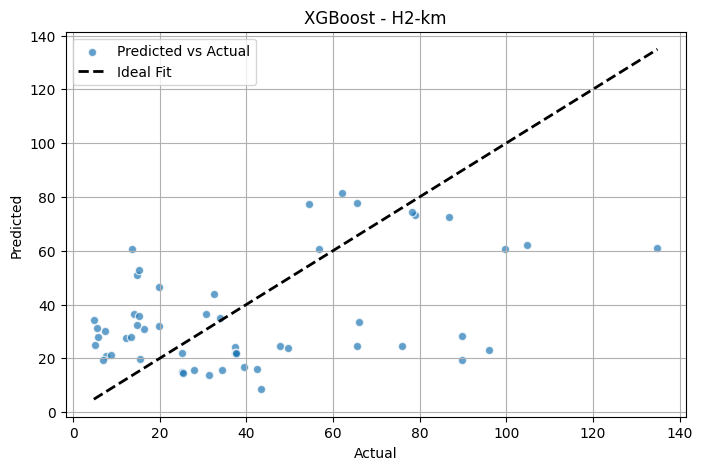


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1866
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 153
[LightGBM] [Info] Start training from score 39.953488
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 42.437209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

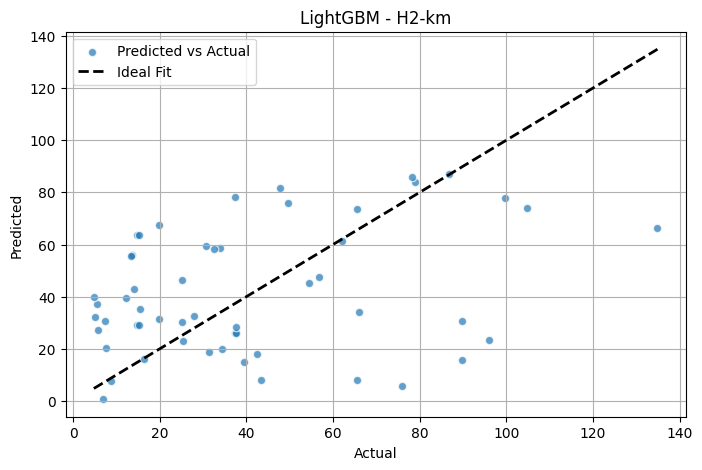


Training CatBoost...
Best parameters for CatBoost: {'learning_rate': 0.1, 'iterations': 200, 'depth': 5}

CatBoost - Mean Squared Error: 599.9664
CatBoost - R-squared: 0.3758


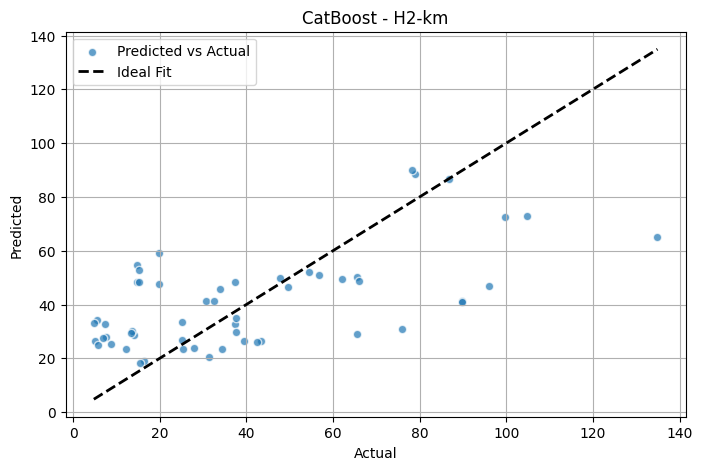


Training RandomForest...
Best parameters for RandomForest: {'n_estimators': 200, 'max_depth': None}

RandomForest - Mean Squared Error: 769.5171
RandomForest - R-squared: 0.1994


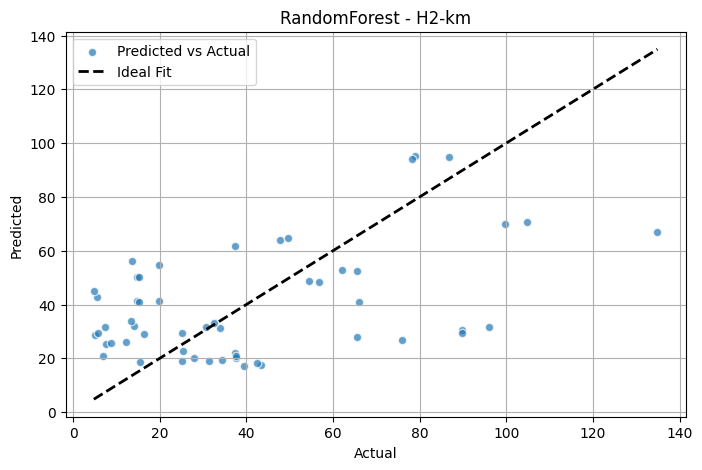


Training ElasticNet...


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.562e+01, tolerance: 4.691e+00
  model = cd_fast.enet_coordinate_descent(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+01, tolerance: 2.921e+00
  model = cd_fast.enet_coordinate_descent(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Best parameters for ElasticNet: {'l1_ratio': 0.2, 'alpha': 1.0}

ElasticNet - Mean Squared Error: 666.2129
ElasticNet - R-squared: 0.3068


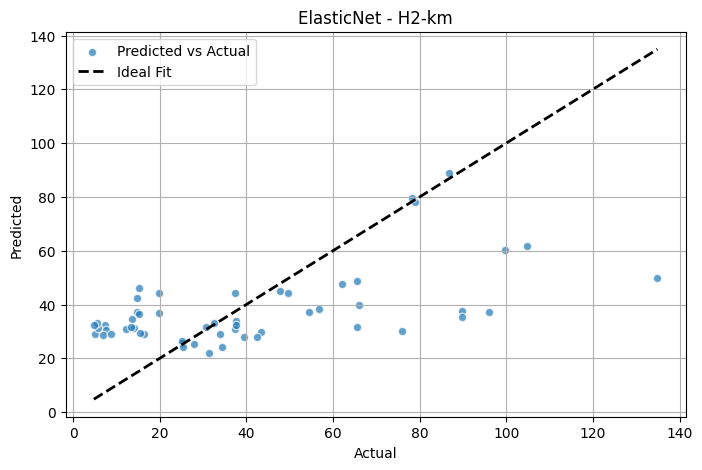


Training kNN...
Best parameters for kNN: {'n_neighbors': 5}

kNN - Mean Squared Error: 813.4293
kNN - R-squared: 0.1537


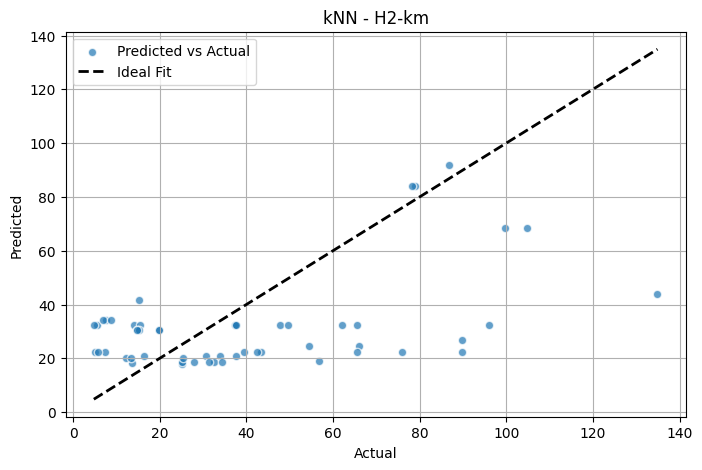


Training Neural Network for H2-km...
1/1 [==============================] - 0s 39ms/step

Neural Network - Mean Squared Error: 97855.1562
Neural Network - R-squared: -100.8136


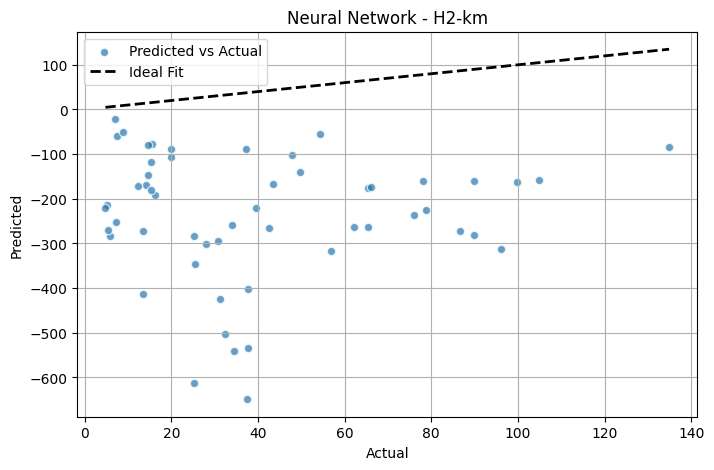

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define a function to create the neural network model
def build_nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Target columns
target_columns = ['ACE-km', 'H2-km']

# Clean and preprocess the dataset (assuming df_use is your dataframe)
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]
df_cleaned.columns = df_cleaned.columns.astype(str)
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]
groups = df_cleaned[digester_columns].idxmax(axis=1)
non_target_columns = df_cleaned.columns.difference(target_columns)
scaler = StandardScaler()
df_cleaned[non_target_columns] = scaler.fit_transform(df_cleaned[non_target_columns])
df_cleaned = df_cleaned.astype(np.float32)

# Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Define parameter grids for each model
param_grids = {
    'xgb': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    'lgbm': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    'catboost': {'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [3, 5]},
    'rf': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
    'elasticnet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]},
    'knn': {'n_neighbors': [3, 5, 7]}
}

# Initialize models
models = {
    'XGBoost': RandomizedSearchCV(XGBRegressor(), param_distributions=param_grids['xgb'], n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1),
    'LightGBM': RandomizedSearchCV(LGBMRegressor(), param_distributions=param_grids['lgbm'], n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1),
    'CatBoost': RandomizedSearchCV(CatBoostRegressor(verbose=0), param_distributions=param_grids['catboost'], n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1),
    'RandomForest': RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_grids['rf'], n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1),
    'ElasticNet': RandomizedSearchCV(ElasticNet(), param_distributions=param_grids['elasticnet'], n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1),
    'kNN': RandomizedSearchCV(KNeighborsRegressor(), param_distributions=param_grids['knn'], n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
}

# Train and evaluate model for each target column
for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values
    X = X.astype(np.float32)
    
    print(f"\n=== Results for target: {target_column} ===")
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        y_tests, y_preds = [], []
        
        # Fit RandomizedSearchCV for non-NN models
        model.fit(X, y)
        best_model = model.best_estimator_
        print(f"Best parameters for {model_name}: {model.best_params_}")
        
        # Get predictions with the best model for each fold
        for train_index, test_index in logo.split(X, y, groups):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            y_tests.extend(y_test)
            y_preds.extend(y_pred)
                
        # Calculate and display metrics
        mse = mean_squared_error(y_tests, y_preds)
        r2 = r2_score(y_tests, y_preds)
        
        print(f"\n{model_name} - Mean Squared Error: {mse:.4f}")
        print(f"{model_name} - R-squared: {r2:.4f}")
        
        # Plot results
        plt.figure(figsize=(8, 5))
        plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
        plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'{model_name} - {target_column}')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Neural Network
    print(f"\nTraining Neural Network for {target_column}...")
    y_tests_nn, y_preds_nn = [], []
    
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        nn_model = build_nn_model(input_shape=X_train.shape[1])
        nn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        y_pred_nn = nn_model.predict(X_test).flatten()
        
        y_tests_nn.extend(y_test)
        y_preds_nn.extend(y_pred_nn)
        
    # Calculate and display metrics for Neural Network
    mse_nn = mean_squared_error(y_tests_nn, y_preds_nn)
    r2_nn = r2_score(y_tests_nn, y_preds_nn)
    
    print(f"\nNeural Network - Mean Squared Error: {mse_nn:.4f}")
    print(f"Neural Network - R-squared: {r2_nn:.4f}")
    
    # Plot results for Neural Network
    plt.figure(figsize=(8, 5))
    plt.scatter(y_tests_nn, y_preds_nn, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests_nn), max(y_tests_nn)], [min(y_tests_nn), max(y_tests_nn)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Neural Network - {target_column}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [17]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 24.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 25.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


------

## Other

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 12s 12s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


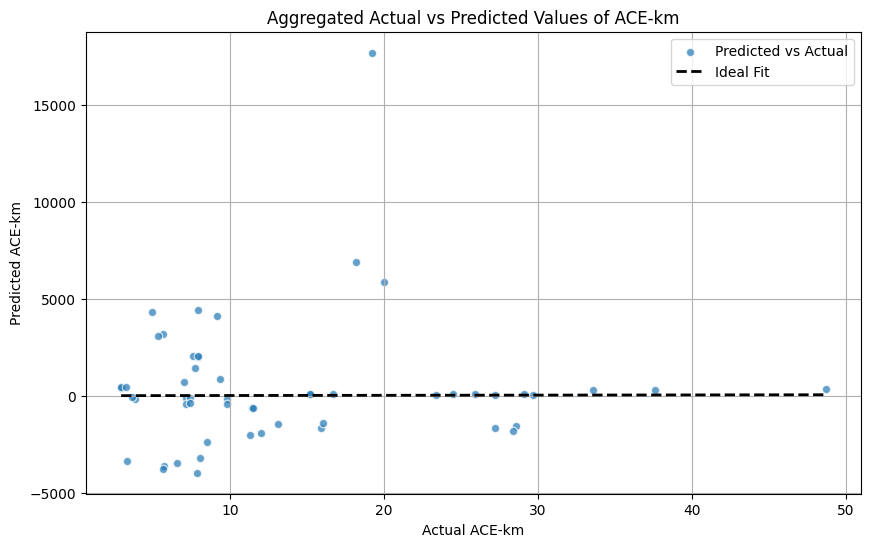


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 10982603.0000
R-squared: -106357.0111


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 5s 5s/step


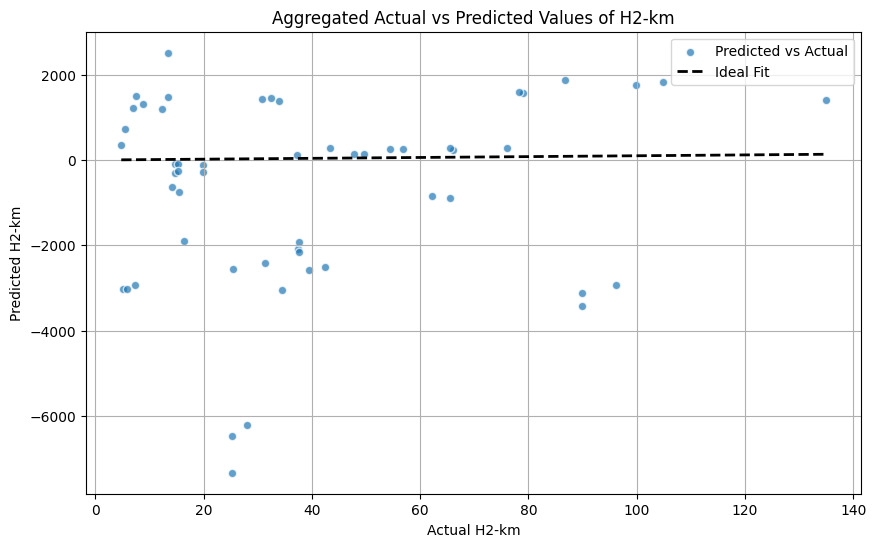


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 5306016.5000
R-squared: -5519.6599


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

target_columns = ['ACE-km', 'H2-km']

df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

groups = df_cleaned[digester_columns].idxmax(axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# df_cleaned[df_cleaned.columns] = scaler.fit_transform(df_cleaned)

df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    
    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        model = build_model((X_train.shape[1], 1))

        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        y_pred = model.predict(X_test).flatten()

        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


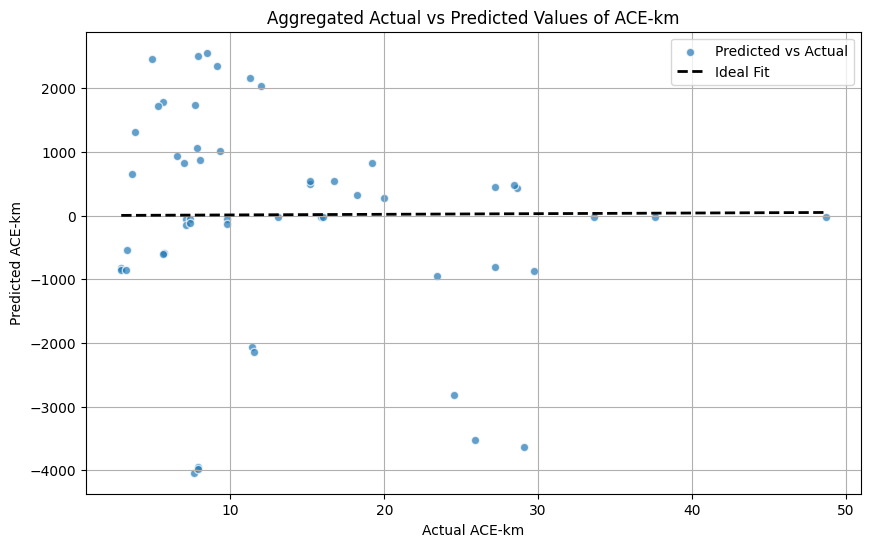


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 2727297.7500
R-squared: -26410.7723


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 7s 7s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


KeyboardInterrupt: 

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

# Your target columns
target_columns = ['ACE-km', 'H2-km']

# Clean the DataFrame by removing rows with 'x' and create a copy to avoid SettingWithCopyWarning
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)].copy()

# Identify digester columns
digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

# Define groups for Leave-One-Group-Out cross-validation
groups = df_cleaned[digester_columns].idxmax(axis=1)

# Remove only target columns from features
feature_columns = df_cleaned.columns.difference(target_columns)

# Standardize the features (excluding target columns)
# scaler = StandardScaler()
# df_cleaned.loc[:, feature_columns] = scaler.fit_transform(df_cleaned[feature_columns])

# Convert DataFrame to float32
df_cleaned = df_cleaned.astype(np.float32)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Loop over each target column
for target_column in target_columns:
    # Prepare features and target
    X = df_cleaned[feature_columns].values  # Includes digester columns
    y = df_cleaned[target_column].values    # Target variable (not scaled)
    
    # Reshape X for Conv1D input: (samples, timesteps, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    y_tests = []
    y_preds = []
    
    # Perform Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Build and train the model
        model = build_model((X_train.shape[1], 1))
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        
        # Make predictions
        y_pred = model.predict(X_test).flatten()
        y_tests.extend(y_test)
        y_preds.extend(y_pred)
    
    # Calculate overall metrics
    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel(f'Actual {target_column}')
    plt.ylabel(f'Predicted {target_column}')
    plt.title(f'Aggregated Actual vs Predicted Values of {target_column}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics
    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


2024-10-25 21:43:29.696098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:44:21.393480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:44:27.374591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:45:19.734341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


2024-10-25 21:45:24.523396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:46:06.662022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:46:15.876774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:47:04.868031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:47:10.923927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:48:04.808431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 21:48:11.167038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:49:07.109796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 21:49:14.189229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:50:04.998497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:50:11.126063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:51:05.283248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 21:51:12.068381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:52:02.771373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:52:11.921173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:53:02.143170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 21:53:08.500246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:53:49.939789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:53:56.158268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:54:45.672500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:54:51.322709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:55:49.593622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:55:55.270931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:56:38.461914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:56:44.124895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:57:31.027031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:57:36.766332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:58:27.230200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 21:58:36.025268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:59:04.408016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


2024-10-25 21:59:09.616562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 21:59:56.817786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


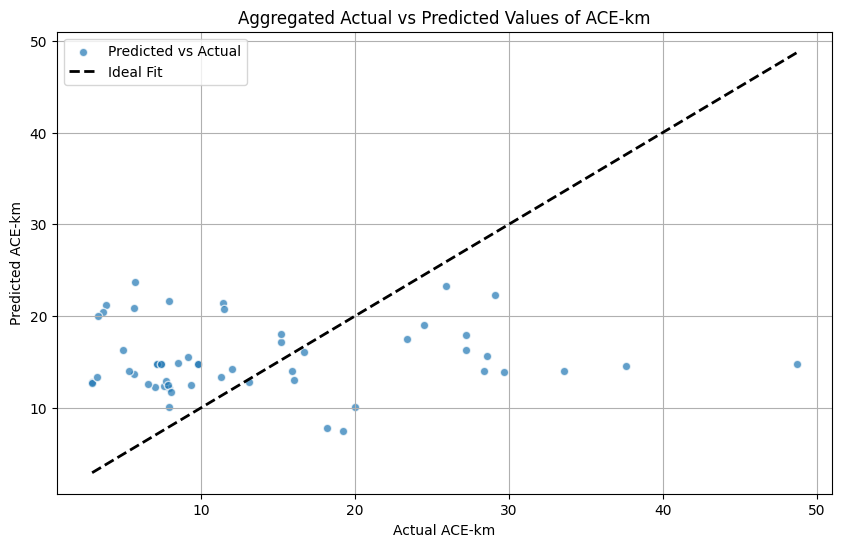


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 116.6112
R-squared: -0.1293


2024-10-25 22:00:02.701022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:00:50.792883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:00:56.820436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:01:45.822449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:01:51.893920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:02:39.344161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:02:45.465736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:03:36.247062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:03:42.248872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:04:33.995559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:04:48.148602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:05:37.857543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 22:05:44.127860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:06:31.330922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:06:37.395343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:07:25.241491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:07:31.027214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:08:19.152558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:08:25.021795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:09:17.888075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 22:09:24.309417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:10:15.613806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:10:25.140525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:11:18.384247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:11:24.508883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:12:15.480725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:12:21.665657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:13:14.879653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 22:13:21.400541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:14:10.651397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 22:14:17.072078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:15:06.081378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-25 22:15:11.933383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:15:41.861224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-25 22:15:48.257577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-25 22:16:41.993984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 9s 9s/step


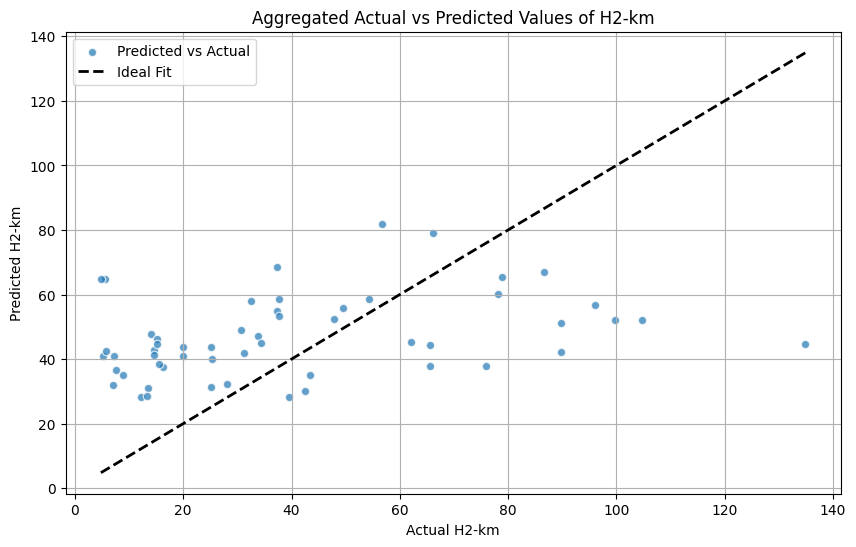


Overall Cross-Validation Metrics for H2-km:
Mean Squared Error: 885.1613
R-squared: 0.0790


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

target_columns = ['ACE-km', 'H2-km']

df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

groups = df_cleaned[digester_columns].idxmax(axis=1)

features = df_cleaned.drop(columns=target_columns)
targets = df_cleaned[target_columns]

scaler = StandardScaler()
# df_cleaned[df_cleaned.columns] = scaler.fit_transform(df_cleaned)

features_scaled = scaler.fit_transform(features)

df_cleaned = pd.DataFrame(features_scaled, columns=features.columns)
df_cleaned[target_columns] = targets.reset_index(drop=True)

# df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    
    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        model = build_model((X_train.shape[1], 1))

        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        y_pred = model.predict(X_test).flatten()

        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


2024-10-27 17:34:54.921062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:36:05.927728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:36:13.103128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:37:13.459217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step


2024-10-27 17:37:21.354473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:38:27.458719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:38:34.078360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:39:28.967138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:39:35.724313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:40:28.776579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step


2024-10-27 17:40:36.348453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:41:44.316180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:41:55.510621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:42:52.094782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:42:58.592957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:43:55.727019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 393ms/step


2024-10-27 17:43:57.002955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:44:56.507681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:45:04.034239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:46:02.858991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-10-27 17:46:08.955035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:47:11.145782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:47:18.365327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:47:51.075862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 445ms/step


2024-10-27 17:47:52.291500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:48:54.462718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:49:01.373511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:50:07.434705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 13s 13s/step


2024-10-27 17:50:17.410611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:51:19.202902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 490ms/step


2024-10-27 17:51:20.484583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:52:08.220528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:52:15.435432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:52:46.116868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


2024-10-27 17:52:53.078735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:53:28.275450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


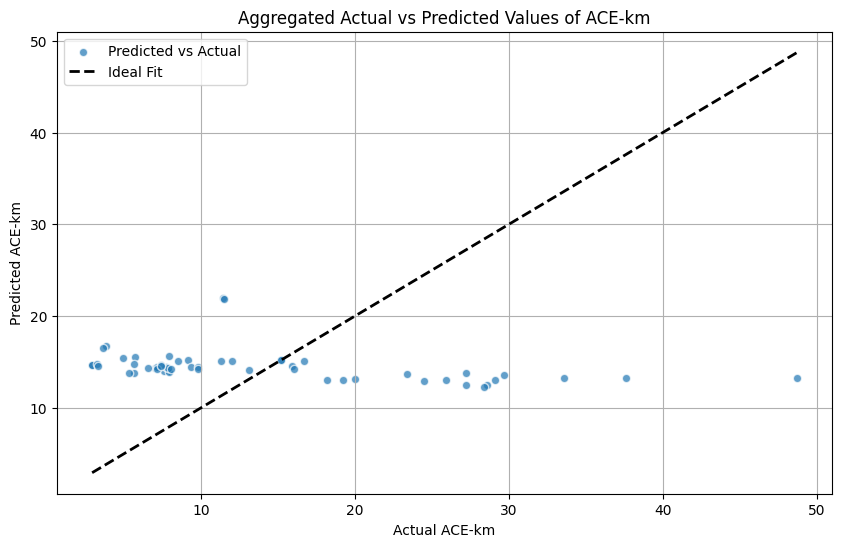


Overall Cross-Validation Metrics for ACE-km:
Mean Squared Error: 120.8898
R-squared: -0.1707


2024-10-27 17:53:35.587783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-27 17:54:23.474182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 630ms/step


2024-10-27 17:54:24.890955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Dropout(0.1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    return model

target_columns = ['ACE-km', 'H2-km']

df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

digester_columns = [col for col in df_cleaned.columns if col.startswith('Digester')]

groups = df_cleaned[digester_columns].idxmax(axis=1)

features = df_cleaned.drop(columns=target_columns)
targets = df_cleaned[target_columns]

# scaler = StandardScaler()
scaler = MinMaxScaler()
# df_cleaned[df_cleaned.columns] = scaler.fit_transform(df_cleaned)

features_scaled = scaler.fit_transform(features)

df_cleaned = pd.DataFrame(features_scaled, columns=features.columns)
df_cleaned[target_columns] = targets.reset_index(drop=True)

# df_cleaned = df_cleaned.astype(np.float32)

logo = LeaveOneGroupOut()

for target_column in target_columns:
    X = df_cleaned.drop(columns=target_columns).values  
    y = df_cleaned[target_column].values

    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32)
    
    y_tests = []
    y_preds = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        model = build_model((X_train.shape[1], 1))

        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        y_pred = model.predict(X_test).flatten()

        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    mse_overall = mean_squared_error(y_tests, y_preds)
    r2_overall = r2_score(y_tests, y_preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_tests, y_preds, alpha=0.7, edgecolors='w', label='Predicted vs Actual')
    plt.plot([min(y_tests), max(y_tests)], [min(y_tests), max(y_tests)], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual ' + target_column)
    plt.ylabel('Predicted ' + target_column)
    plt.title('Aggregated Actual vs Predicted Values of ' + target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nOverall Cross-Validation Metrics for {target_column}:")
    print(f"Mean Squared Error: {mse_overall:.4f}")
    print(f"R-squared: {r2_overall:.4f}")


----------

In [29]:
print(df_cleaned[['ACE-km', 'H2-km']].head())  # Ensure these values match your expectations


   ACE-km      H2-km
0     2.9   7.300000
1     2.9   5.100000
2     3.2   5.800000
3    11.3  25.400000
4     8.5  34.400002


## Given Code

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

# Your target columns
target_columns = ['ACE-km', 'H2-km']

# Assuming df_use is your initial DataFrame
df_cleaned = df_use[~df_use.isin(['x']).any(axis=1)]

# Identify digester columns
digester_columns = [col for col in df_cleaned.columns if col.startswith('digester')]

# Prepare the data
X = df_cleaned.drop(columns=target_columns)
y = df_cleaned[target_columns]  # Now includes multiple target variables

# **Do not remove digester columns from X**
# X = X.drop(columns=digester_columns)  # Commented out as digester columns are features

# Define and Compile Model
def build_model(input_shape, output_shape):
    # Define model
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(output_shape)
    ])

    # Compile Model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
    
    return model

# Initialize variables
ann_predictions = pd.DataFrame(columns=target_columns)
history_cache = []

# Loop over each digester for leave-one-digester-out cross-validation
for fold, digester in enumerate(digester_columns):
    # Identify validation samples (samples belonging to the current digester)
    val_indices = df_cleaned[df_cleaned[digester] == 1].index
    X_val = X.loc[val_indices]
    y_val = y.loc[val_indices]
    
    # Identify training samples (samples not belonging to the current digester)
    train_indices = df_cleaned[df_cleaned[digester] != 1].index
    X_train = X.loc[train_indices]
    y_train = y.loc[train_indices].values  # Shape (num_samples, num_targets)
    
    # Reshape data for neural network
    X_train_nn = np.expand_dims(X_train.values, axis=2)
    X_val_nn = np.expand_dims(X_val.values, axis=2)
    
    # Build and train the model
    model = build_model((X_train.shape[1], 1), len(target_columns))
    history = model.fit(X_train_nn, y_train, batch_size=32, epochs=150, verbose=0, validation_data=(X_val_nn, y_val))
    
    # Predict on validation data
    predictions = model.predict(X_val_nn)  # Shape (num_samples, num_targets)
    pred_df = pd.DataFrame(predictions, index=val_indices, columns=target_columns)
    ann_predictions = ann_predictions.append(pred_df)
    history_cache.append(history)
    
    # Print status update
    print("--------[{}/{}]--------".format(fold+1, len(digester_columns)))
    for idx in val_indices:
        print("Validation Sample:", idx)
        for target in target_columns:
            print("ANN Prediction for {}: {:.5f}".format(target, pred_df.loc[idx, target]))
            print("Ground Truth for {}: {:.5f}\n".format(target, y.loc[idx, target]))
            
# Ensure ann_predictions are in the same order as y
ann_predictions = ann_predictions.loc[y.index]

# Compute R2 score for each target
print("\nCross Validation Results:\n")
for target in target_columns:
    ann_r2 = r2_score(y[target], ann_predictions[target])
    print("Neural Network R2 Score for {}: {:.5f}".format(target, ann_r2))


KeyError: "None of [Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 18, 19, 20, 21, 22, 23,\n       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,\n       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],\n      dtype='int64')] are in the [index]"

In [25]:
tf.config.run_functions_eagerly(True)
